In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.unfolding_flow import UnfoldingFlow

import numpy as np
#import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from collections import defaultdict
from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak
import random
import pandas as pd

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi


In [2]:
torch.cuda.device_count()

0

In [3]:
batchSize = 1024

path_data = '/work/adpetre/MEMFlow/scripts/../../dataset/v7/'

device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify the GPU ids

#basedir_flow = "/work/adpetre/MEMFlow/scripts/preTraining_7August/preTraining_noProv:True_cartesian:False_HuberLoss:True_latent_space:True_hiddenFeatures:64_dimFeedForward:1024_nheadEnc:8_LayersEnc:4_nheadDec:8_LayersDec:4/UnfFlowEps_BiasMetric_MDMM_HuberLoss_LatentSpace_14August/results_DiagNormal_FirstArg:0_Autoreg:False_NoTransf:20_NoBins:30_DNN:6:128_epsMDMM:0.8/"
basedir_flow= "/work/dvalsecc/MEM/models_archive/flow_nopretraining_v1/results_nopreTraining-v3_v3_DiagNormal_FirstArg:0_Autoreg:False_NoTransf:10_NoBins:35_DNN:4:128_epsMDMM:1.5/"
#basedir_flow= "/work/adpetre/MEMFlow/scripts/lxplus/FirstFlow_HuberLoss_5Sept/results_DiagNormal_FirstArg:0_Autoreg:False_NoTransf:20_NoBins:30_DNN:6:128_epsMDMM:0.8/TryContTr_6Sept/results_DiagNormal_FirstArg:0_Autoreg:False_NoTransf:20_NoBins:30_DNN:6:128_epsMDMM:0.8/"

path_flow = basedir_flow + '/model_flow.pt'
path_to_conf = basedir_flow + 'config_nopreTraining-v3_v3.yaml'

with open(path_to_conf) as f:
        conf = OmegaConf.load(path_to_conf)

model = UnfoldingFlow(model_path=path_flow,
                    read_CondTransf=False,
                    log_mean = conf.scaling_params.log_mean,
                    log_std = conf.scaling_params.log_std,
                    no_jets=conf.input_shape.number_jets,
                    no_lept=conf.input_shape.number_lept,
                    input_features=conf.input_shape.input_features,
                    cond_hiddenFeatures=conf.conditioning_transformer.hidden_features,
                    cond_dimFeedForward=conf.conditioning_transformer.dim_feedforward_transformer,
                    cond_outFeatures=conf.conditioning_transformer.out_features,
                    cond_nheadEncoder=conf.conditioning_transformer.nhead_encoder,
                    cond_NoLayersEncoder=conf.conditioning_transformer.no_layers_encoder,
                    cond_nheadDecoder=conf.conditioning_transformer.nhead_decoder,
                    cond_NoLayersDecoder=conf.conditioning_transformer.no_layers_decoder,
                    cond_NoDecoders=conf.conditioning_transformer.no_decoders,
                    cond_aggregate=conf.conditioning_transformer.aggregate,
                    use_latent=conf.conditioning_transformer.use_latent,
                    flow_nfeatures=conf.unfolding_flow.nfeatures,
                    flow_ncond=conf.unfolding_flow.ncond, 
                    flow_ntransforms=conf.unfolding_flow.ntransforms,
                    flow_hiddenMLP_NoLayers=conf.unfolding_flow.hiddenMLP_NoLayers, 
                    flow_hiddenMLP_LayerDim=conf.unfolding_flow.hiddenMLP_LayerDim,
                    flow_bins=conf.unfolding_flow.bins,
                    flow_autoregressive=conf.unfolding_flow.autoregressive,
                    flow_base=conf.unfolding_flow.base,
                    flow_base_first_arg=conf.unfolding_flow.base_first_arg,
                    flow_base_second_arg=conf.unfolding_flow.base_second_arg,
                    flow_bound=conf.unfolding_flow.bound,
                    device=device,
                    dtype=torch.float64).to(device)


state_dict = torch.load(path_flow, map_location=torch.device("cpu"))
model.load_state_dict(state_dict['model_state_dict'])

# model = torch.nn.DataParallel(model)
model.to(device)

UnfoldingFlow(
  (cond_transformer): ConditioningTransformerLayer(
    (lin_input): Linear(in_features=4, out_features=127, bias=True)
    (lin_boost): Linear(in_features=4, out_features=127, bias=True)
    (gelu): GELU(approximate='none')
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncod

In [6]:
E_CM = 13000
phasespace = PhaseSpace(E_CM, [21,21], [25,6,-6,21])

conf.input_dataset = "/work/dvalsecc/MEM/datasets/all_jets_fullRun2_v1"

if (conf.cartesian):
    data = DatasetCombined(conf.input_dataset, dev=device, dtype=torch.float64, build=False,
                                reco_list=['scaledLogRecoParticlesCartesian', 'mask_lepton', 
                                            'mask_jets','mask_met',
                                            'mask_boost', 'data_boost'],
                                parton_list=['phasespace_intermediateParticles_onShell',
                                            'phasespace_rambo_detjacobian_onShell'])
else:
    data = DatasetCombined(conf.input_dataset, dev=device, dtype=torch.float64, build=False,
                                reco_list=['scaledLogRecoParticles', 'mask_lepton', 
                                            'mask_jets','mask_met',
                                            'mask_boost', 'data_boost'],
                                parton_list=['phasespace_intermediateParticles_onShell',
                                            'phasespace_rambo_detjacobian_onShell',
                                             'data_higgs_t_tbar_ISR_cartesian',
                                             'data_boost'
                                            ])

    
# data_loader = DataLoader(dataset=data, shuffle=False, batch_size=256)
# dataCorrect = data.parton_data.data_higgs_t_tbar_ISR_cartesian
# PS_target = data.parton_data.phasespace_intermediateParticles_onShell

# higgsCorrect = vector.array(
#     {
#         "E": dataCorrect[:,0,0].detach().numpy(),
#         "px": dataCorrect[:,0,1].detach().numpy(),
#         "py": dataCorrect[:,0,2].detach().numpy(),
#         "pz": dataCorrect[:,0,3].detach().numpy(),
#     }
# )

# thadCorrect = vector.array(
#     {
#         "E": dataCorrect[:,1,0].detach().numpy(),
#         "px": dataCorrect[:,1,1].detach().numpy(),
#         "py": dataCorrect[:,1,2].detach().numpy(),
#         "pz": dataCorrect[:,1,3].detach().numpy(),
#     }
# )

# tlepCorrect = vector.array(
#     {
#         "E": dataCorrect[:,2,0].detach().numpy(),
#         "px": dataCorrect[:,2,1].detach().numpy(),
#         "py": dataCorrect[:,2,2].detach().numpy(),
#         "pz": dataCorrect[:,2,3].detach().numpy(),
#     }
# )

# glISRCorrect = vector.array(
#     {
#         "E": dataCorrect[:,3,0].detach().numpy(),
#         "px": dataCorrect[:,3,1].detach().numpy(),
#         "py": dataCorrect[:,3,2].detach().numpy(),
#         "pz": dataCorrect[:,3,3].detach().numpy(),
#     }
# )

# higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
# thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
# tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
# glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")


RecoLevel
Reading reco_level Files
Load scaledLogRecoParticles

PartonLevel
Reading parton_level Files
Load phasespace_intermediateParticles_onShell



In [7]:
def plot_var2d(higgs_var1, higgs_var2, thad_var1, thad_var2, tlep_var1, tlep_var2,
             ISR_var1, ISR_var2, name1, name2, nameFig, start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
             higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, neg_Mask=False, log=False, name='da', nameunit=''):
        
        
        if neg_Mask:
            higgs_mask = np.logical_not(higgs_mask)
            thad_mask = np.logical_not(thad_mask)
            tlep_mask = np.logical_not(tlep_mask)
            ISR_mask = np.logical_not(ISR_mask)

        # Quick construction, no other imports needed:
        hist2d_var_higgs = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_thad = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_tlep = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_ISR = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_higgs.fill(higgs_var1[higgs_mask],
                            higgs_var2[higgs_mask])

        hist2d_var_thad.fill(thad_var1[thad_mask],
                            thad_var2[thad_mask])

        hist2d_var_tlep.fill(tlep_var1[tlep_mask],
                            tlep_var2[tlep_mask])

        hist2d_var_ISR.fill(ISR_var1[ISR_mask],
                            ISR_var2[ISR_mask])

        colormap='viridis'
        my_viridis = mpl.colormaps[colormap].with_extremes(under="white")
        
        fontsize = 20
        labelsize=14
        labels = ['higgs', 'thad', 'tlep', 'ISR']
        hist2d_list = [hist2d_var_higgs, hist2d_var_thad, hist2d_var_tlep, hist2d_var_ISR]
        
        
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))

        if log:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, norm=mpl.colors.LogNorm(vmin=1))
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

        else:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, vmin=1)
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

In [8]:
def get_particle_awkward(momenta):
    
    higgs = momenta[:,0]
    thad = momenta[:,1]
    tlep = momenta[:,2]
    ISR = momenta[:,3]
    
    higgs = vector.array(
                {
                "E": higgs[:,0].detach().numpy(),
                "px": higgs[:,1].detach().numpy(),
                "py": higgs[:,2].detach().numpy(),
                "pz": higgs[:,3].detach().numpy()
                }
            )

    thad = vector.array(
                {
                "E": thad[:,0].detach().numpy(),
                "px": thad[:,1].detach().numpy(),
                "py": thad[:,2].detach().numpy(),
                "pz":thad[:,3].detach().numpy(),
                }
            )

    tlep = vector.array(
                {
                "E": tlep[:,0].detach().numpy(),
                "px": tlep[:,1].detach().numpy(),
                "py": tlep[:,2].detach().numpy(),
                "pz": tlep[:,3].detach().numpy(),
                }
            )
    
    ISR = vector.array(
                {
                "E": ISR[:,0].detach().numpy(),
                "px": ISR[:,1].detach().numpy(),
                "py": ISR[:,2].detach().numpy(),
                "pz": ISR[:,3].detach().numpy(),
                }
            )
    
    higgs = ak.with_name(higgs, name="Momentum4D")
    thad = ak.with_name(thad, name="Momentum4D")
    tlep = ak.with_name(tlep, name="Momentum4D")
    ISR = ak.with_name(ISR, name="Momentum4D")
    
    return higgs, thad, tlep, ISR

def get_particle_awkward_samples(momenta):
    
    higgs = momenta[:,:,2]
    thad = momenta[:,:,3]
    tlep = momenta[:,:,4]
    ISR = momenta[:,:,5]
    
    higgs = vector.array(
                {
                "E": higgs[:,:,0].detach().numpy(),
                "px": higgs[:,:,1].detach().numpy(),
                "py": higgs[:,:,2].detach().numpy(),
                "pz": higgs[:,:,3].detach().numpy()
                }
            )

    thad = vector.array(
                {
                "E": thad[:,:,0].detach().numpy(),
                "px": thad[:,:,1].detach().numpy(),
                "py": thad[:,:,2].detach().numpy(),
                "pz":thad[:,:,3].detach().numpy(),
                }
            )

    tlep = vector.array(
                {
                "E": tlep[:,:,0].detach().numpy(),
                "px": tlep[:,:,1].detach().numpy(),
                "py": tlep[:,:,2].detach().numpy(),
                "pz": tlep[:,:,3].detach().numpy(),
                }
            )
    
    ISR = vector.array(
                {
                "E": ISR[:,:,0].detach().numpy(),
                "px": ISR[:,:,1].detach().numpy(),
                "py": ISR[:,:,2].detach().numpy(),
                "pz": ISR[:,:,3].detach().numpy(),
                }
            )
    
    higgs = ak.with_name(higgs, name="Momentum4D")
    thad = ak.with_name(thad, name="Momentum4D")
    tlep = ak.with_name(tlep, name="Momentum4D")
    ISR = ak.with_name(ISR, name="Momentum4D")
    
    return higgs, thad, tlep, ISR



def get_diff(C, C_samples, Nsamples):
    # Diff between target quantity in awkward array and samples of the same quantity
    return torch.from_numpy(ak.to_numpy(C_samples)) - torch.from_numpy(ak.to_numpy(C)).unsqueeze(1).expand(-1, Nsamples)

def get_std(C_samples): 
    return np.nanstd(ak.to_numpy(C_samples), axis=1)

# Testing the model sampling

In [9]:
indices = list(range(50))

In [10]:
logScaled_reco = data.reco_data.scaledLogRecoParticles[indices]
mask_lepton_reco = data.reco_data.mask_lepton[indices]
mask_jets = data.reco_data.mask_jets[indices]
mask_met = data.reco_data.mask_met[indices]
mask_boost_reco = data.reco_data.mask_boost[indices]
data_boost_reco = data.reco_data.data_boost[indices]
boost_parton = data.parton_data.data_boost[indices]
parton_cartesian = data.parton_data.data_higgs_t_tbar_ISR_cartesian_onShell[indices]

In [11]:
model = model.to(device)

In [13]:
cond_X = model(mask_jets=mask_jets, mask_lepton_reco=mask_lepton_reco,
                            mask_met=mask_met, mask_boost_reco=mask_boost_reco,
                            logScaled_reco=logScaled_reco, data_boost_reco=data_boost_reco, 
                            device=device, noProv=conf.noProv, eps=conf.training_params.eps,
                            order=conf.training_params.order)

#print(f'after model, before sampling: PS_regressed: {PS_regressed.shape}')

In [14]:
cond_X

tensor([[ 0.0424,  0.0430, -1.0658,  ...,  0.8946,  1.6587,  0.7784],
        [ 0.1521,  0.1518, -0.9878,  ...,  0.5646,  1.1931,  1.1178],
        [-0.0297, -0.0363, -0.6024,  ...,  0.9265,  0.8891,  1.6285],
        ...,
        [-0.0235, -0.0207, -0.6534,  ...,  1.1450,  1.9551,  1.3639],
        [-0.0369, -0.0414, -0.4050,  ...,  0.7459,  0.6457,  0.9518],
        [ 0.0025,  0.0050, -0.5295,  ...,  0.8352,  1.0595,  0.9231]],
       grad_fn=<CatBackward0>)

In [15]:
ps_new = model.flow(cond_X).sample((4056,))

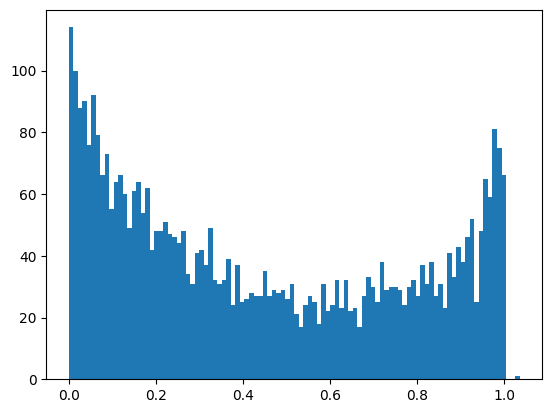

In [16]:
plt.hist(ps_new[:,0,2].cpu(), bins=100);

In [17]:
(ps_new > 1).sum()

tensor(599)

In [18]:
(ps_new<0).sum(dim=[0, 2]) / 2048

tensor([0.0078, 0.0015, 0.0034, 0.0010, 0.0049, 0.0063, 0.0093, 0.0005, 0.0020,
        0.0000, 0.0000, 0.0010, 0.0029, 0.0044, 0.0063, 0.0005, 0.0015, 0.0005,
        0.0020, 0.0049, 0.0015, 0.0005, 0.0146, 0.0029, 0.0073, 0.0083, 0.0024,
        0.0034, 0.0020, 0.0054, 0.0039, 0.0039, 0.0029, 0.0010, 0.0054, 0.0029,
        0.0020, 0.0015, 0.0063, 0.0010, 0.0112, 0.0005, 0.0044, 0.0020, 0.0049,
        0.0000, 0.0034, 0.0083, 0.0000, 0.0000])

In [19]:
(ps_new>1).sum(dim=[0, 2]) / 2048

tensor([0.0176, 0.0024, 0.0024, 0.0195, 0.0073, 0.0098, 0.0195, 0.0005, 0.0024,
        0.0078, 0.0049, 0.0049, 0.0044, 0.0073, 0.0137, 0.0010, 0.0029, 0.0117,
        0.0015, 0.0078, 0.0024, 0.0024, 0.0059, 0.0029, 0.0049, 0.0059, 0.0015,
        0.0098, 0.0005, 0.0122, 0.0049, 0.0010, 0.0142, 0.0029, 0.0020, 0.0020,
        0.0054, 0.0005, 0.0054, 0.0010, 0.0010, 0.0000, 0.0039, 0.0190, 0.0122,
        0.0010, 0.0010, 0.0137, 0.0024, 0.0015])

In [17]:
(ps_new > 1).sum()/ (ps_new > 0).sum()

tensor(0.0007, device='cuda:0')

In [18]:
model.log_mean

tensor([ 4.6831e+00, -1.2350e-04,  3.3137e-04], device='cuda:0')

In [20]:
ps_new_flat = ps_new.flatten(0, 1)
momenta, weight, x1pp, x2pp = phasespace.get_momenta_from_ps(ps_new_flat)
momenta_original = momenta.reshape(-1,ps_new.shape[1], 6, 4).transpose(1, 0)
x1pp = x1pp.reshape(-1, ps_new.shape[1]).transpose(1,0)
x2pp = x2pp.reshape(-1, ps_new.shape[1]).transpose(1,0)
H, t1, t2, isr = get_particle_awkward(parton_cartesian)
Hs, t1s, t2s, isrs = get_particle_awkward_samples(momenta_original.cpu())

HttISR_regressed, boost_regressed = Compute_ParticlesTensor.get_HttISR_numpy(cond_X, model.log_mean,
                                                                                         model.log_std, device, 1e-5)
#momenta_regressed, _, _, _ = phasespace.get_momenta_from_ps(PS_regressed)

Hr, t1r, t2r, isrr = get_particle_awkward(HttISR_regressed.cpu())


x1 = (boost_parton[:,0,0]+boost_parton[:,0,3])/E_CM
x2 = (boost_parton[:,0,0]-boost_parton[:,0,3])/E_CM

IndexError: too many indices for tensor of dimension 2

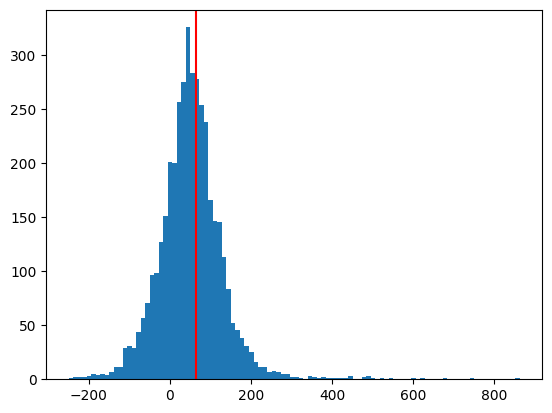

In [21]:
plt.hist(momenta_original[1, :, 3, 3].cpu(), bins=100);
plt.axvline(parton_cartesian[1, 0,3], c="red")

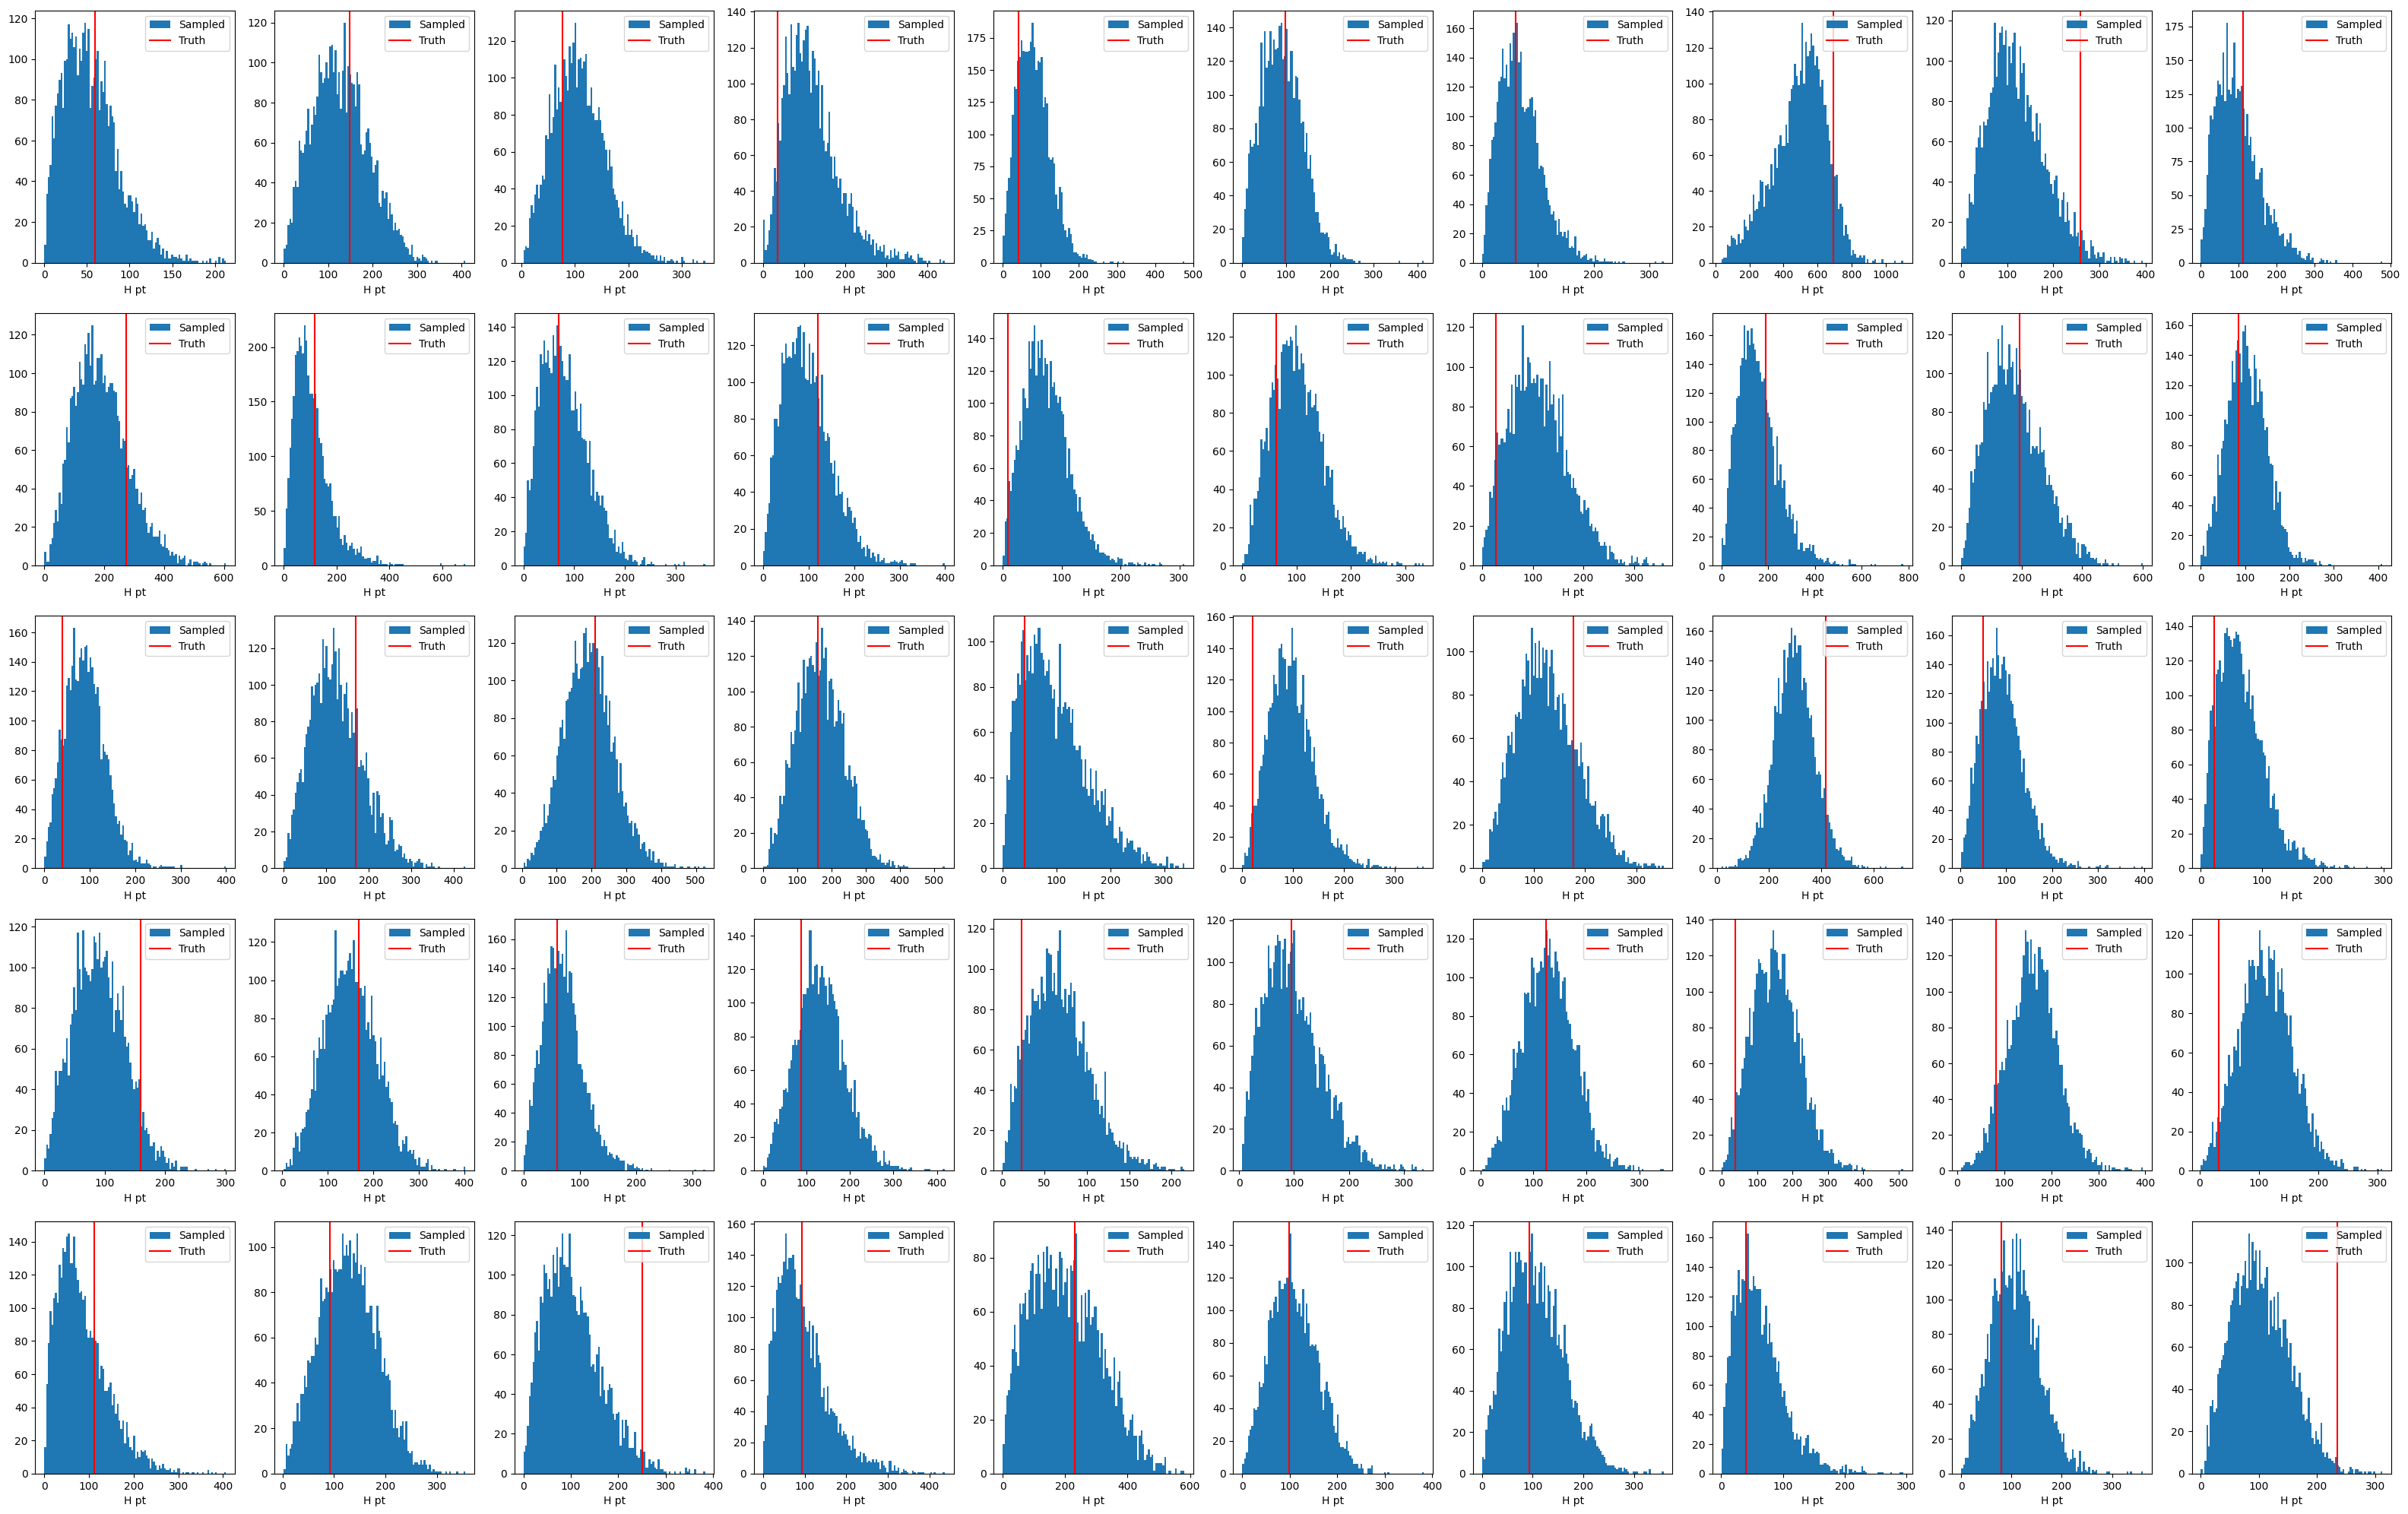

In [22]:
f, axs = plt.subplots(5, 10, figsize=(40, 25))

for i in range(5):
    for j in range(10):
        n = i*10 + j
        axs[i][j].hist(Hs[n].pt, bins=100, label="Sampled");
        #axs[i][j].axvline(Hr[n].pt, c="green", label="Regressed")
        axs[i][j].axvline(H[n].pt, c="red", label="Truth")
        axs[i][j].set_xlabel("H pt")
        axs[i][j].legend()

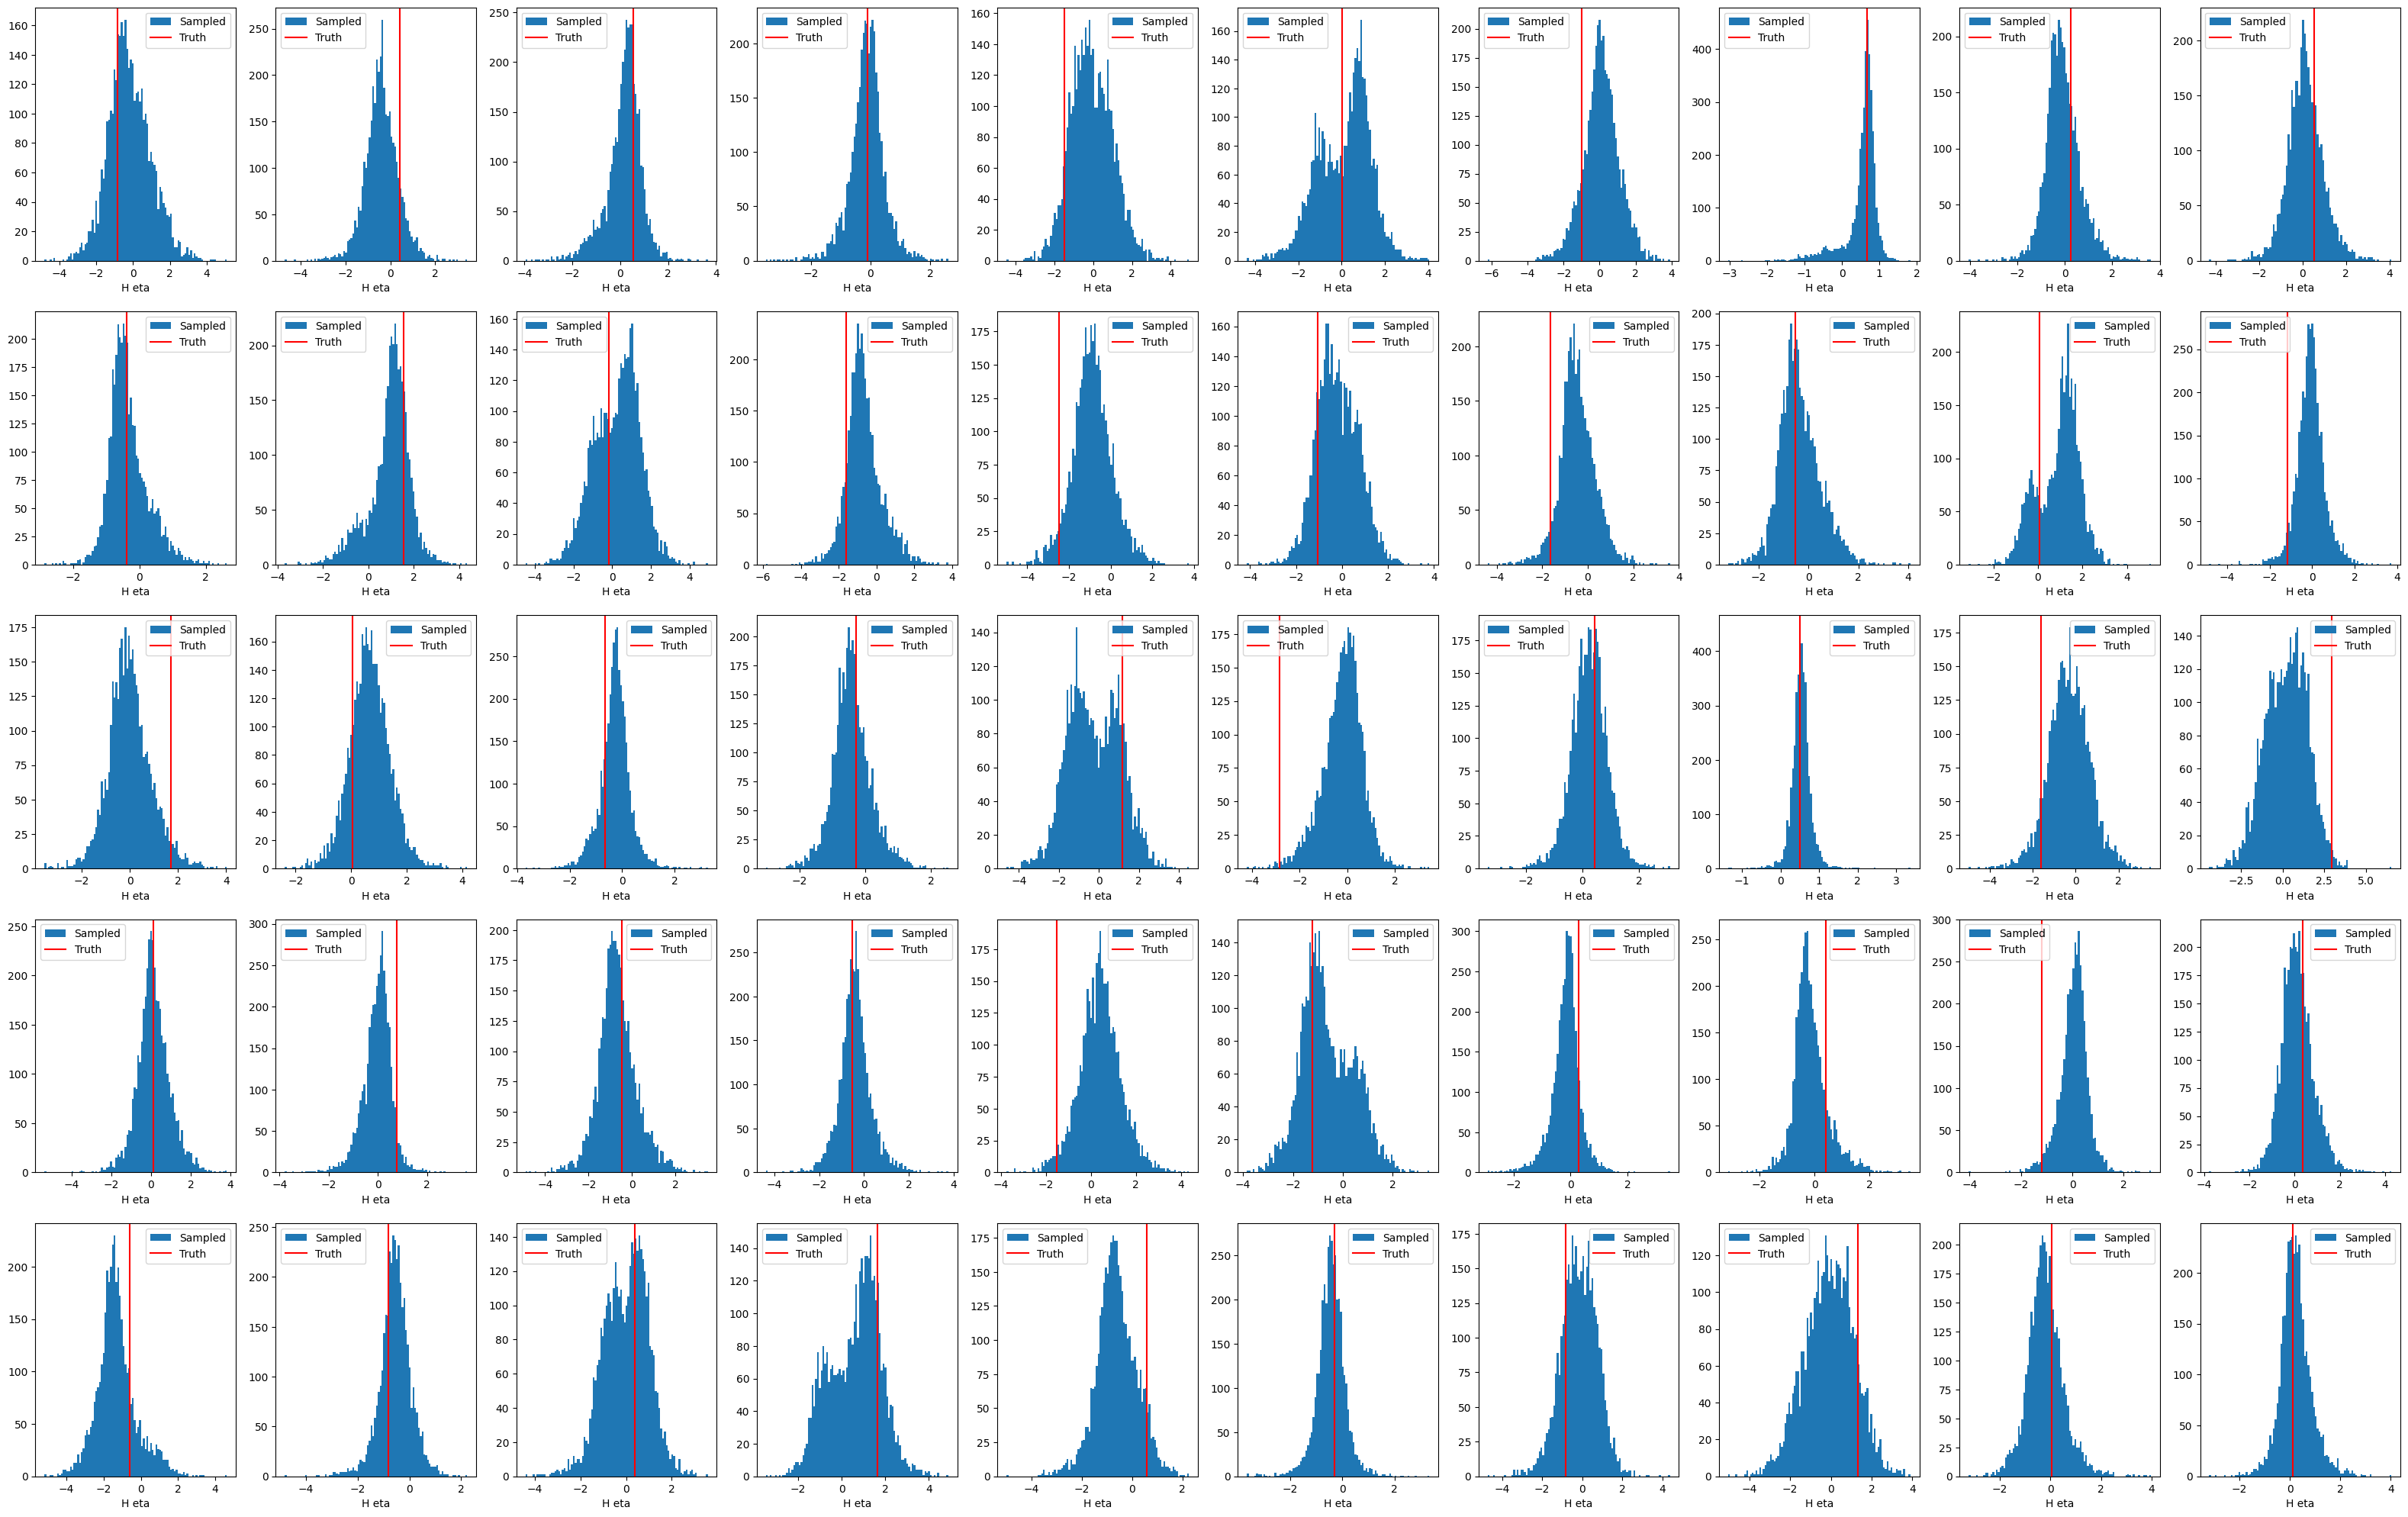

In [23]:
f, axs = plt.subplots(5, 10, figsize=(40, 25))

for i in range(5):
    for j in range(10):
        n = i*10 + j
        axs[i][j].hist(Hs[n].eta, bins=100, label="Sampled");
        #axs[i][j].axvline(Hr[n].eta, c="green", label="Regressed")
        axs[i][j].axvline(H[n].eta, c="red", label="Truth")
        axs[i][j].set_xlabel("H eta")
        axs[i][j].legend()

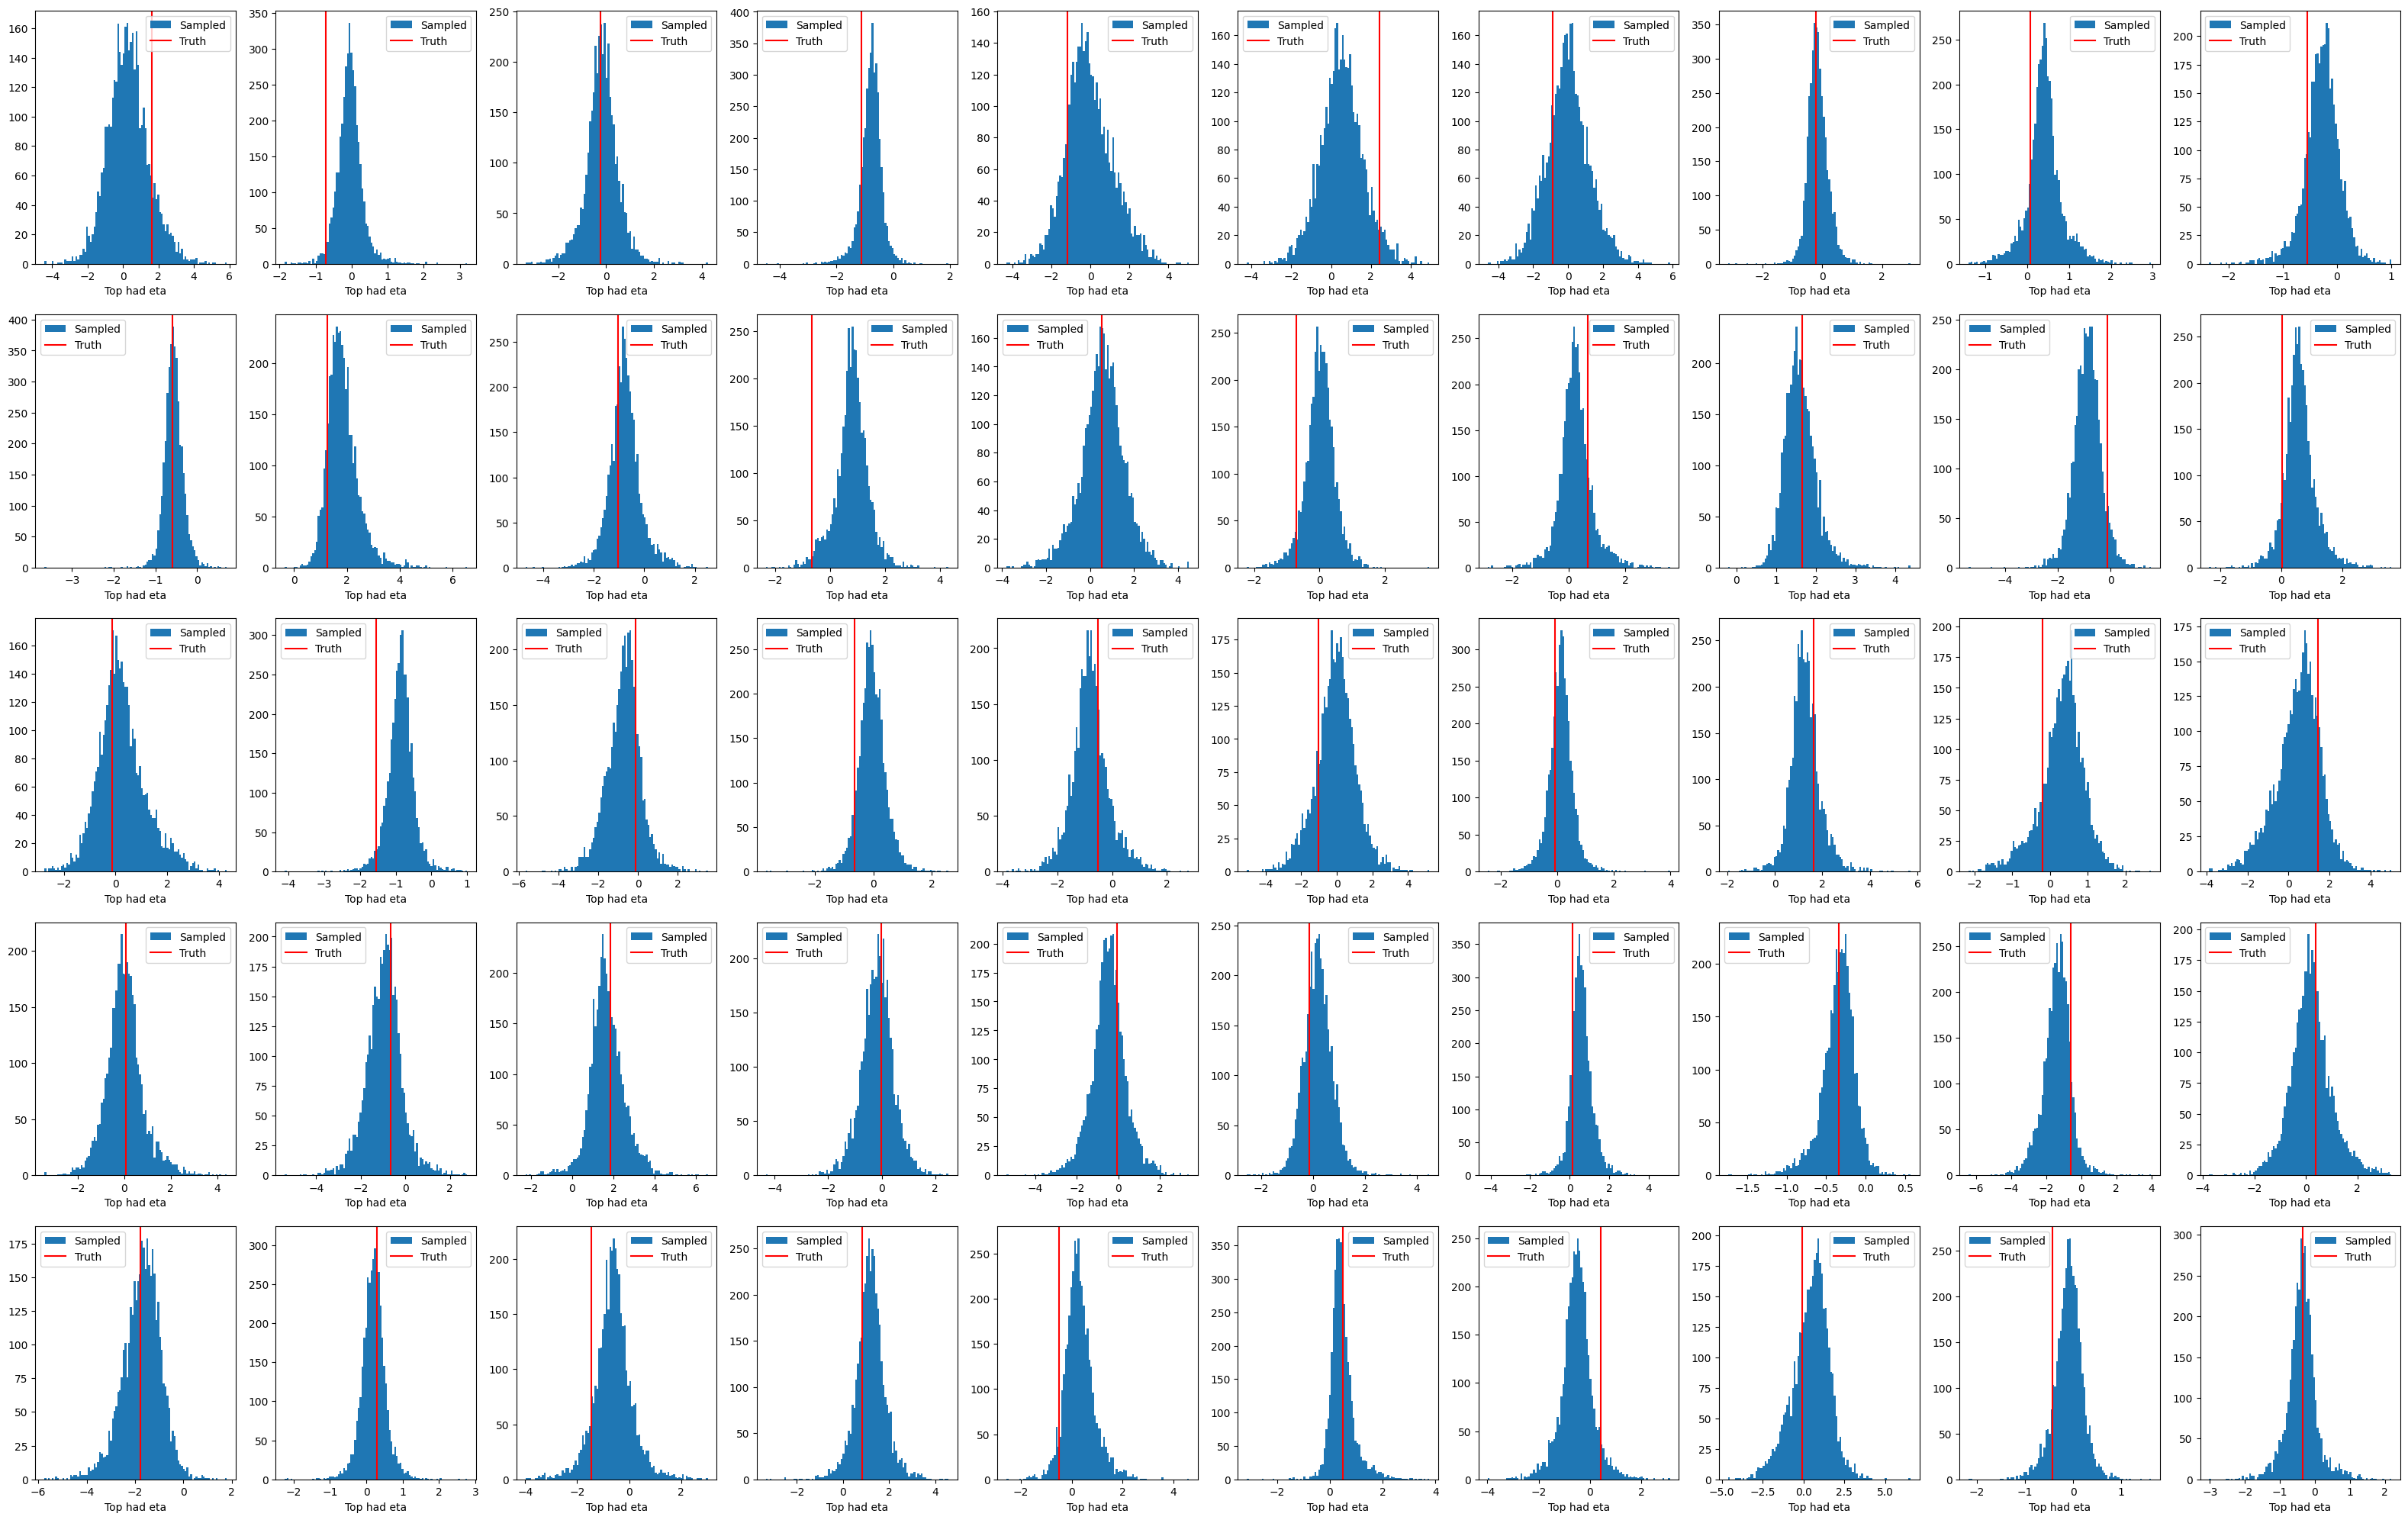

In [28]:
f, axs = plt.subplots(5, 10, figsize=(40, 25))

for i in range(5):
    for j in range(10):
        n = i*10 + j
        axs[i][j].hist(t2s[n].eta, bins=100, label="Sampled");
        #axs[i][j].axvline(Hr[n].eta, c="green", label="Regressed")
        axs[i][j].axvline(t2[n].eta, c="red", label="Truth")
        axs[i][j].set_xlabel("Top had eta")
        axs[i][j].legend()

# Routine to evaluate samples quality

In [24]:
def get_performance_metrics(data, Nsamples=1024): 

    (ps_target, ps_rambo_detjac, partons_cartesian, boost_parton, 
     logScaled_reco, mask_lepton_reco, 
     mask_jets, mask_met, 
     mask_boost_reco, data_boost_reco) = data

    cond_X, PS_regressed = model(mask_jets=mask_jets, mask_lepton_reco=mask_lepton_reco,
                            mask_met=mask_met, mask_boost_reco=mask_boost_reco,
                            logScaled_reco=logScaled_reco, data_boost_reco=data_boost_reco, 
                            device=device, noProv=conf.noProv, eps=conf.training_params.eps,
                            order=conf.training_params.order)

    ps_new = model.flow(PS_regressed).sample((Nsamples,))
    ps_new_flat = ps_new.flatten(0, 1)
    momenta, weight, x1pp, x2pp = phasespace.get_momenta_from_ps(ps_new_flat)
    x1pp = x1pp.reshape(-1, ps_new.shape[1]).transpose(1,0)
    x2pp = x2pp.reshape(-1, ps_new.shape[1]).transpose(1,0)
    momenta = momenta.reshape(-1,ps_new.shape[1], 6, 4).transpose(1, 0)

    
    x1 = (boost_parton[:,0,0]+boost_parton[:,0,3])/E_CM
    x2 = (boost_parton[:,0,0]-boost_parton[:,0,3])/E_CM

    H, t1, t2, isr = get_particle_awkward(partons_cartesian.cpu())
    Hs, t1s, t2s, isrs = get_particle_awkward_samples(momenta.cpu())

    diff_H_pt = get_diff(H.pt, Hs.pt, Nsamples)
    diff_H_eta = get_diff(H.eta, Hs.eta, Nsamples)
    diff_H_phi = get_diff(H.phi, Hs.phi, Nsamples)

    diff_t1_pt = get_diff(t1.pt, t1s.pt, Nsamples)
    diff_t1_eta = get_diff(t1.eta, t1s.eta, Nsamples)
    diff_t1_phi = get_diff(t1.phi, t1s.phi, Nsamples)

    diff_t2_pt = get_diff(t2.pt, t2s.pt, Nsamples)
    diff_t2_eta = get_diff(t2.eta, t2s.eta, Nsamples)
    diff_t2_phi = get_diff(t2.phi, t2s.phi, Nsamples)

    diff_isr_pt = get_diff(isr.pt, isrs.pt, Nsamples)
    diff_isr_eta = get_diff(isr.eta, isrs.eta, Nsamples)
    diff_isr_phi = get_diff(isr.phi, isrs.phi, Nsamples)

    out = {

        "H_pt": ak.to_numpy(H.pt),
        "H_eta": ak.to_numpy(H.eta),
        "H_phi": ak.to_numpy(H.phi),
        "t1_pt": ak.to_numpy(t1.pt),
        "t1_eta": ak.to_numpy(t1.eta),
        "t1_phi": ak.to_numpy(t1.phi),
        "t2_pt": ak.to_numpy(t2.pt),
        "t2_eta": ak.to_numpy(t2.eta),
        "t2_phi": ak.to_numpy(t2.phi),
        "isr_pt": ak.to_numpy(isr.pt),
        "isr_eta": ak.to_numpy(isr.eta),
        "isr_phi": ak.to_numpy(isr.phi),
        "Njets": mask_jets.sum(1).cpu().numpy(),
        "x1":  x1.cpu().numpy(),
        "x2":  x2.cpu().numpy(),

        
        "delta_x1": (x1pp - x1.unsqueeze(1).expand(-1, Nsamples)).nanmean(1).cpu().numpy(),
        "delta_x2": (x2pp - x2.unsqueeze(1).expand(-1, Nsamples)).nanmean(1).cpu().numpy(),

        "sigma_x1": x1pp.std(1).cpu().numpy(),
        "sigma_x2":  x2pp.std(1).cpu().numpy(),
        
        "delta_H_pt": diff_H_pt.nanmean(1),
        "delta_H_eta": diff_H_eta.nanmean(1),
        "delta_H_phi": diff_H_phi.nanmean(1),
        
        "delta_t1_pt": diff_t1_pt.nanmean(1),
        "delta_t1_eta": diff_t1_eta.nanmean(1),
        "delta_t1_phi": diff_t1_phi.nanmean(1),
        
        "delta_t2_pt": diff_t2_pt.nanmean(1),
        "delta_t2_eta": diff_t2_eta.nanmean(1),
        "delta_t2_phi": diff_t2_phi.nanmean(1),

        "delta_isr_pt": diff_isr_pt.nanmean(1),
        "delta_isr_eta": diff_isr_eta.nanmean(1),
        "delta_isr_phi": diff_isr_phi.nanmean(1),

        "sigma_H_pt": get_std(Hs.pt),
        "sigma_H_eta": get_std(Hs.eta),
        "sigma_H_phi": get_std(Hs.phi),

        "sigma_t1_pt": get_std(t1s.pt),
        "sigma_t1_eta": get_std(t1s.eta),
        "sigma_t1_phi": get_std(t1s.phi),
        
        "sigma_t2_pt": get_std(t2s.pt),
        "sigma_t2_eta": get_std(t2s.eta),
        "sigma_t2_phi": get_std(t2s.phi),

        "sigma_isr_pt": get_std(isrs.pt),
        "sigma_isr_eta": get_std(isrs.eta),
        "sigma_isr_phi": get_std(isrs.phi),
    }
    return out
    
    

In [24]:
data_loader = DataLoader(dataset=data, shuffle=False, batch_size=128)
data_loader_256 = DataLoader(dataset=data, shuffle=False, batch_size=256)
data_loader_512 = DataLoader(dataset=data, shuffle=False, bqatch_size=512)

In [20]:
o =  get_performance_metrics(batch_data, 1024)

In [52]:
%%timeit
get_performance_metrics(batch_data, 512)

4.54 s ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
batch_data_256 = next(iter(data_loader_256))
batch_data_512 = next(iter(data_loader_512))

In [56]:
%%timeit
get_performance_metrics(batch_data_256, 512)

8.87 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
( ps_target, ps_rambo_detjac, partons_cartesian, boost_parton, 
     logScaled_reco, mask_lepton_reco, 
     mask_jets, mask_met, 
     mask_boost_reco, data_boost_reco) = next(iter(data_loader_256))

In [25]:
results = []
nbatches = 300
for b, batch_data in enumerate(data_loader_256):
    if b == nbatches: break
    print(b, end=" ")
    results.append(get_performance_metrics(batch_data, 300))

0 

/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1734: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 

KeyboardInterrupt: 

In [26]:
total = {}
for k in results[0].keys():
    total[k] = np.stack([v[k] for v in results],0).flatten()

df = pd.DataFrame(total) 

df.to_csv("bias_analysis_dump.csv", index=False,sep=";")

In [27]:
def plot_results(df, var, xrange=None, xrange2=None):
    f, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=100)
    axs[0].hist(df[f"delta_{var}"], bins=100, range=xrange if xrange else None);
    axs[1].hist(df[f"sigma_{var}"], bins=100, range=xrange2 if xrange2 else None);
    axs[0].set_xlabel(f"delta_{var}")
    axs[1].set_xlabel(f"sigma_{var}")
    f.show()

/tmp/ipykernel_28966/991933038.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


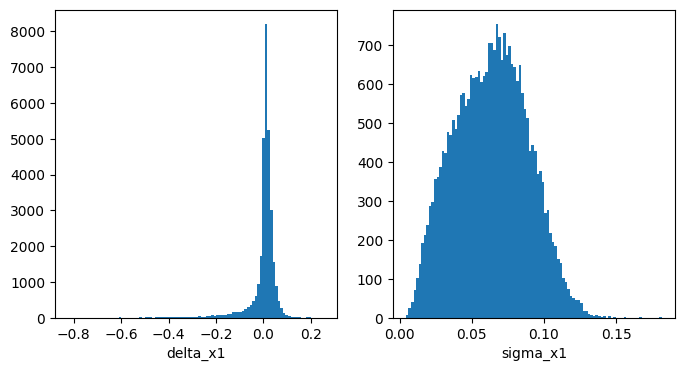

In [28]:
plot_results(df, "x1")

/tmp/ipykernel_28966/991933038.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


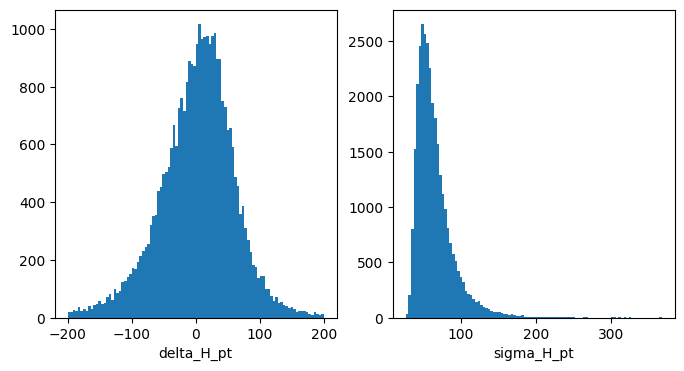

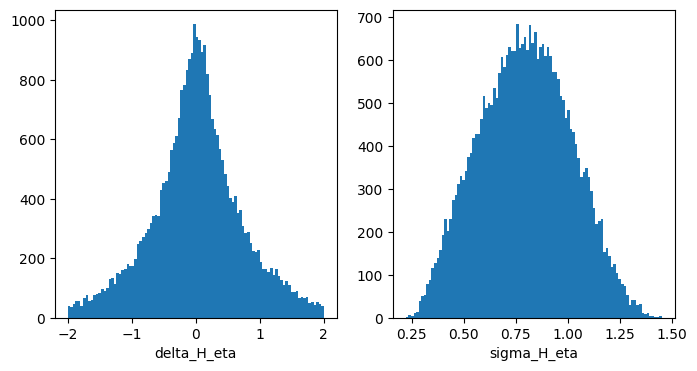

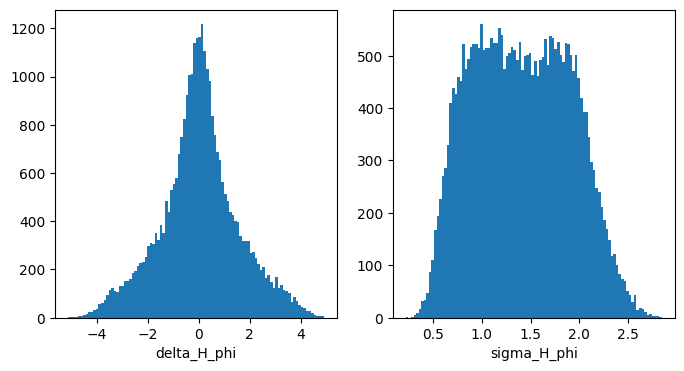

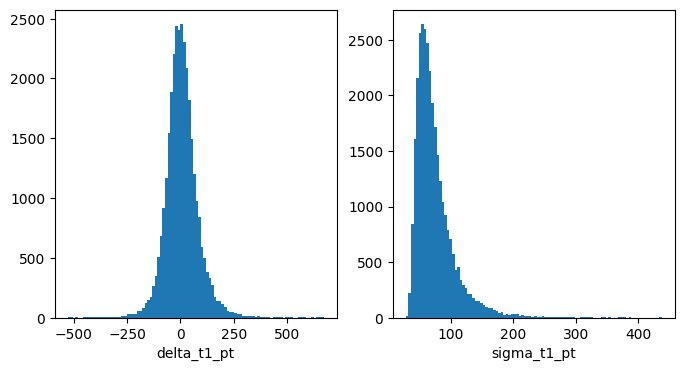

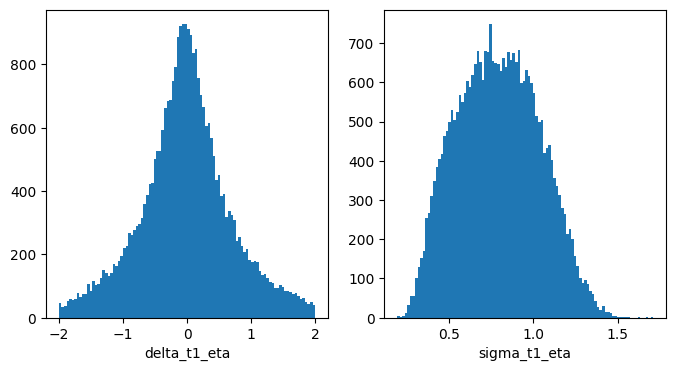

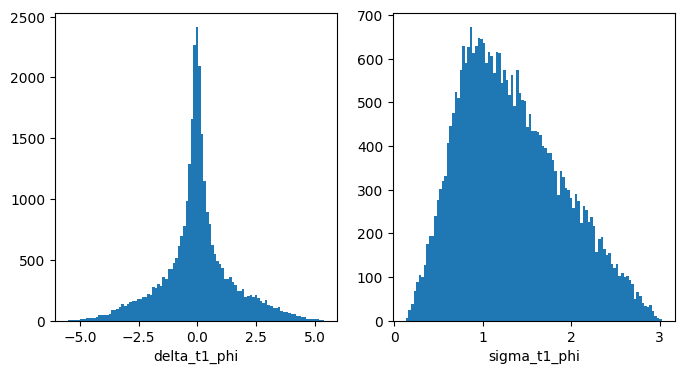

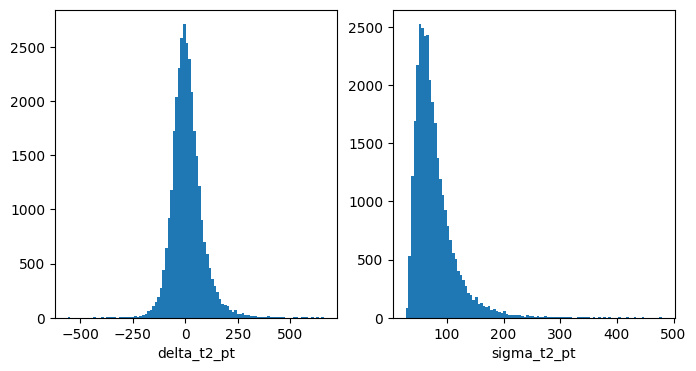

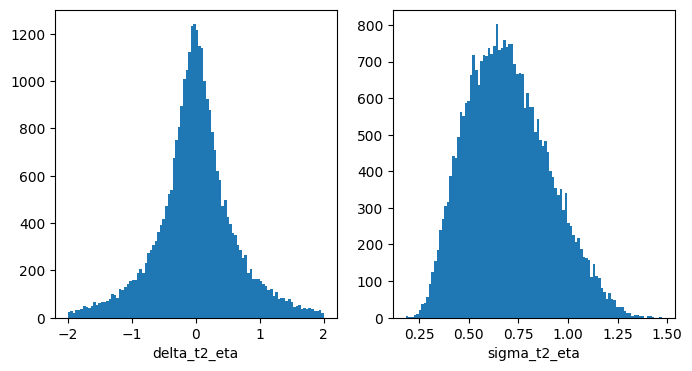

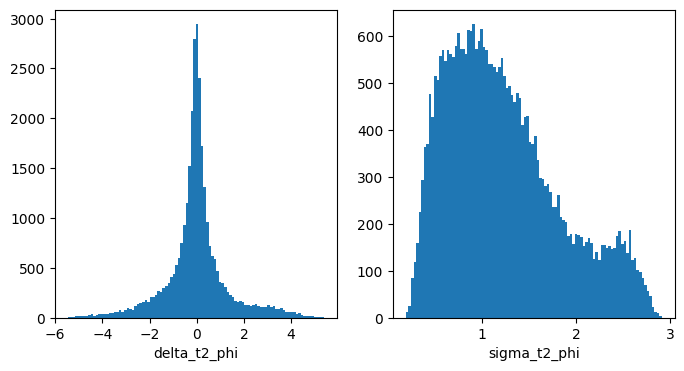

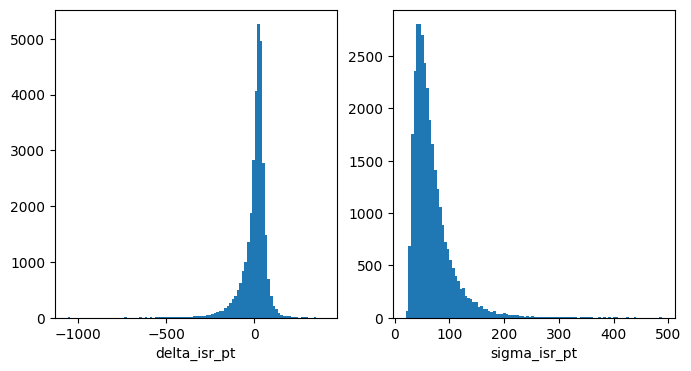

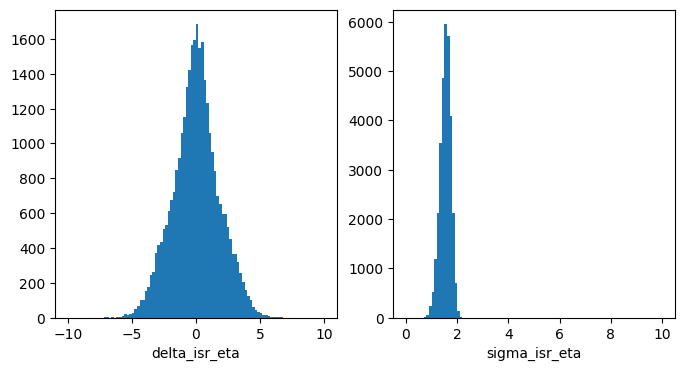

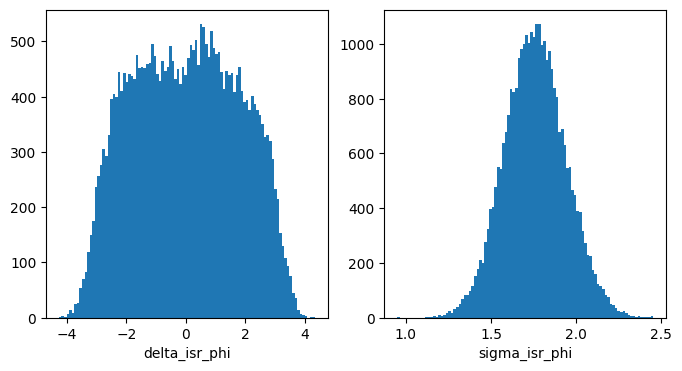

In [29]:
plot_results(df, "H_pt", xrange=(-200,200))
plot_results(df, "H_eta", xrange=(-2,2))
plot_results(df, "H_phi")
plot_results(df, "t1_pt")
plot_results(df, "t1_eta", xrange=(-2,2))
plot_results(df, "t1_phi")
plot_results(df, "t2_pt")
plot_results(df, "t2_eta",xrange=(-2,2))
plot_results(df, "t2_phi")
plot_results(df, "isr_pt")
plot_results(df, "isr_eta", xrange=(-10,10), xrange2=(0, 10))
plot_results(df, "isr_phi")

(array([8.5910e+03, 1.6319e+04, 1.4329e+04, 7.5530e+03, 3.0350e+03,
        9.8300e+02, 2.8600e+02, 7.6000e+01, 2.5000e+01, 3.0000e+00]),
 array([ 4. ,  4.9,  5.8,  6.7,  7.6,  8.5,  9.4, 10.3, 11.2, 12.1, 13. ]),
 <BarContainer object of 10 artists>)

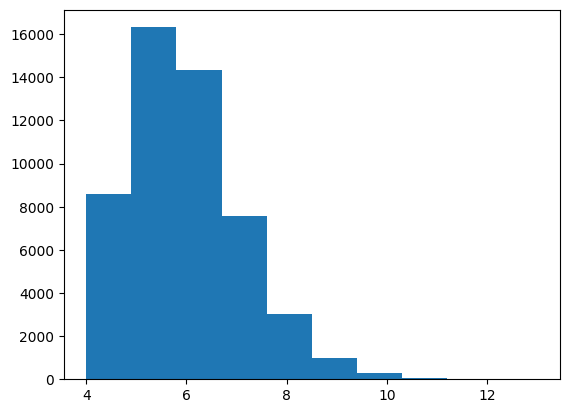

In [46]:
plt.hist(df.Njets)

/tmp/ipykernel_28966/991933038.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


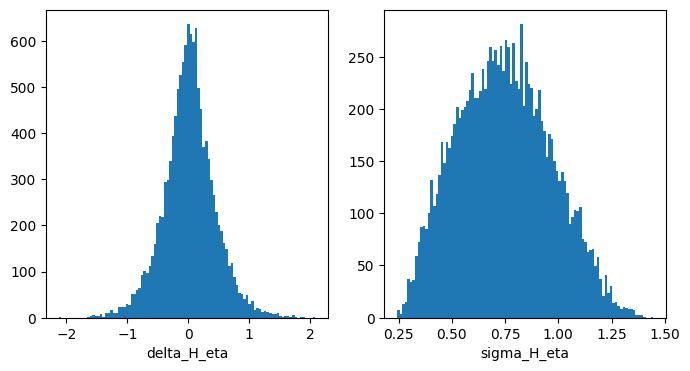

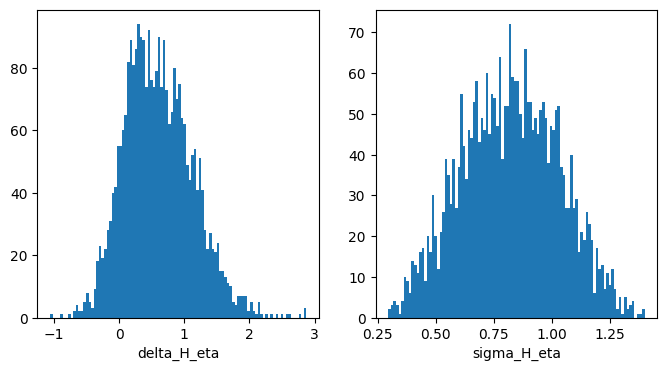

In [30]:
plot_results(df[(df.H_eta<0.5)&(df.H_eta>-0.5)], "H_eta",)
plot_results(df[(df.H_eta<-0.8)&(df.H_eta>-1.2)], "H_eta",)


/tmp/ipykernel_28966/991933038.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


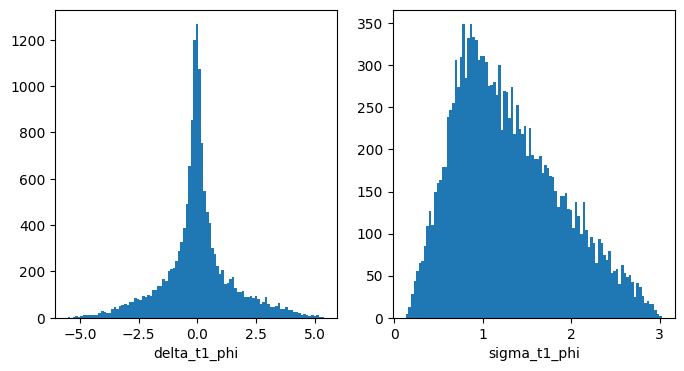

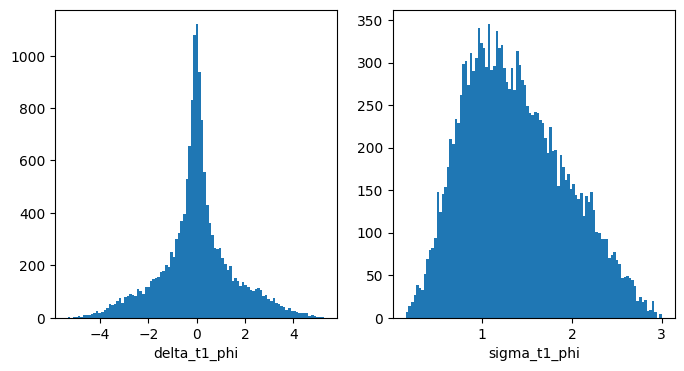

In [31]:
plot_results(df[df.Njets<6], "t1_phi",)
plot_results(df[df.Njets>=6], "t1_phi")

### Higgs sampling performance

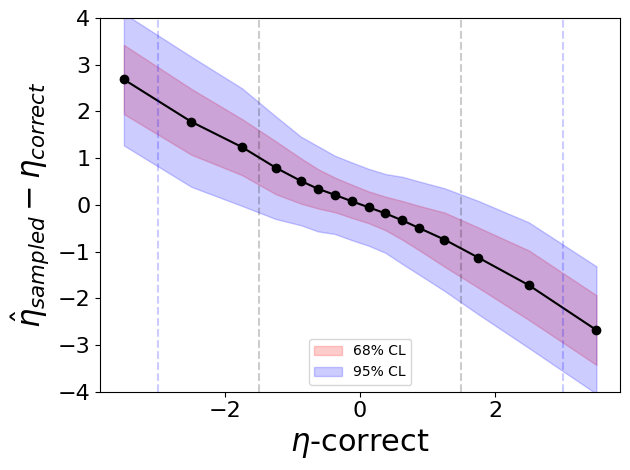

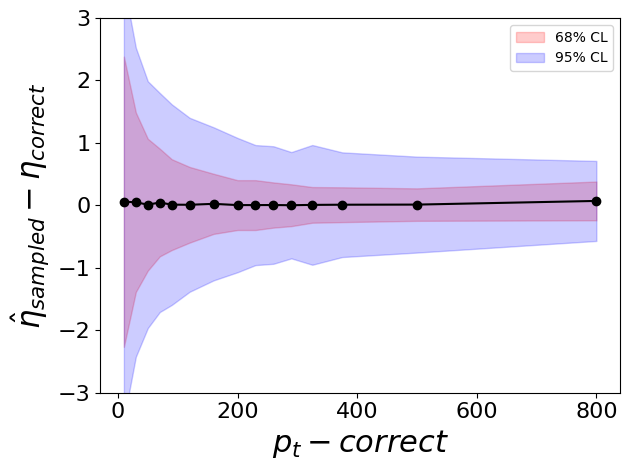

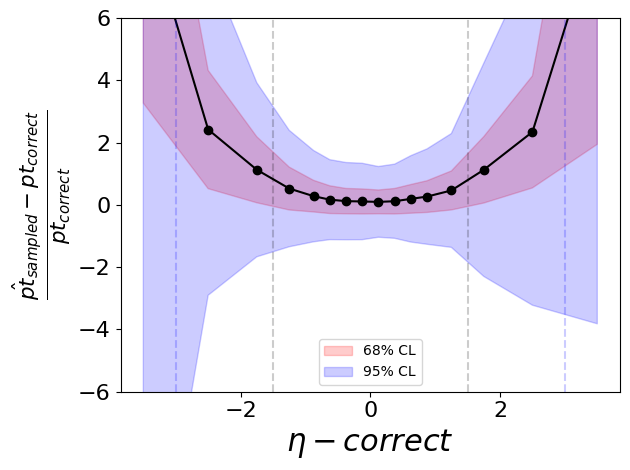

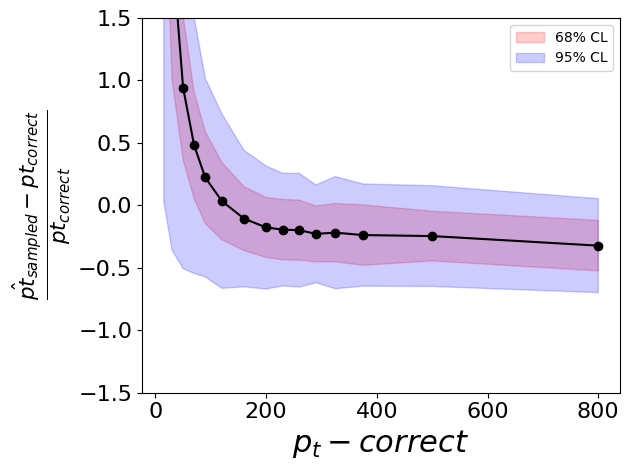

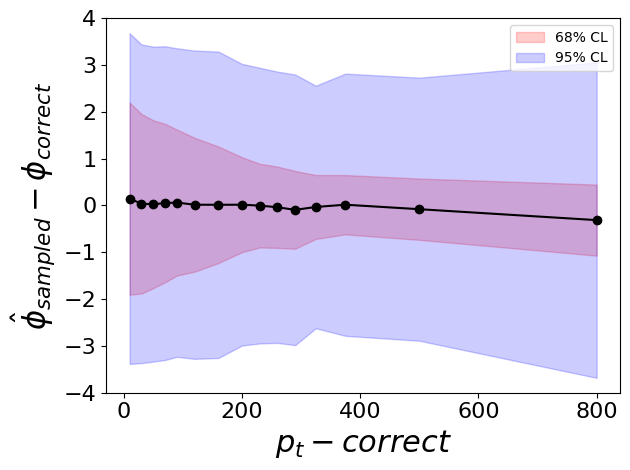

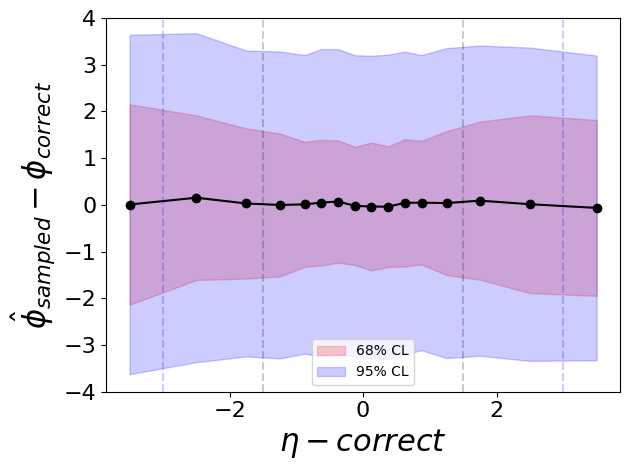

In [35]:
plot_regressionFactor(df.H_eta + df.delta_H_eta, df.H_eta, df.H_eta, matched=df.Njets>2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$\eta$-correct',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$', eta=True, ratio=False)

plot_regressionFactor(df.H_eta+df.delta_H_eta, df.H_eta,  df.H_pt,  matched=df.Njets>2,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-3,3], xname='$p_t-correct$',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$')

plot_regressionFactor(df.H_pt+df.delta_H_pt, df.H_pt, df.H_eta, matched=df.Njets >2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-5, 5), bins=8, ylim=[-6,6], xname='$\eta-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True)

plot_regressionFactor(df.H_pt+df.delta_H_pt, df.H_pt, df.H_pt,  matched=df.Njets >2,
                      intervalTargetVar=[10,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-1.5,1.5], xname='$p_t-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', ratio=True)

plot_regressionFactor(df.H_phi+df.delta_H_phi, df.H_phi, df.H_pt, matched=df.Njets>2,
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$')


plot_regressionFactor(df.H_phi+df.delta_H_phi, df.H_phi, df.H_eta, matched=df.Njets>2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-4,4], xname='$\eta-correct$',
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$', eta=True)


### Boost analysis

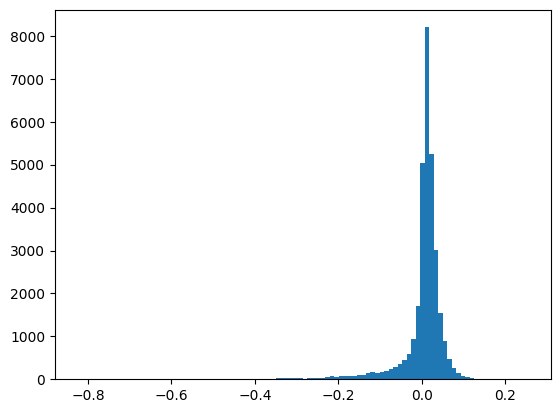

In [36]:
plt.hist(df.delta_x1, bins=100);

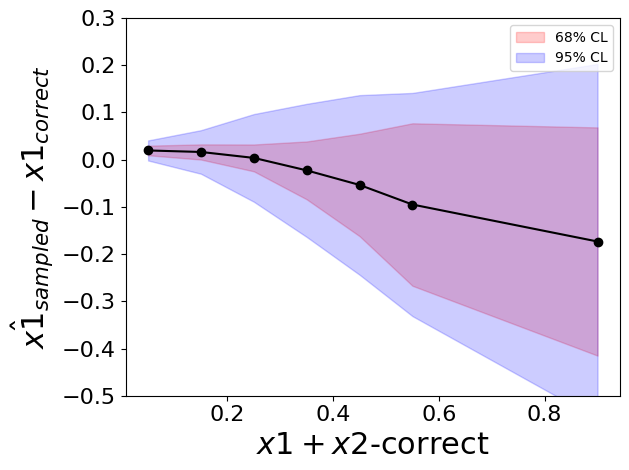

In [37]:
plot_regressionFactor(df.x1+df.delta_x1, df.x1, df.x1+df.x2, matched=df.Njets>2,
                      intervalTargetVar=[0, 0.1, 0.2, 0.3,0.4,0.5,0.6, 1.2],
                      limTarget=(0, 1000), bins=20, ylim=[-0.5,0.3], xname='$x1+x2$-correct',
                      yname=r'$\hat{x1}_{sampled} - x1_{correct}$', eta=False, ratio=False)

### T hadronic sampling performance

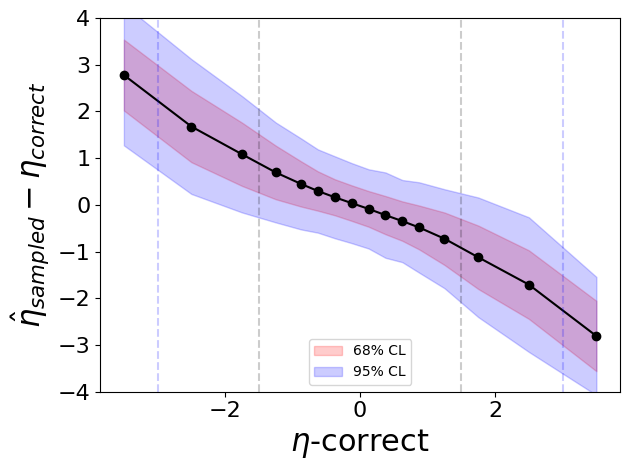

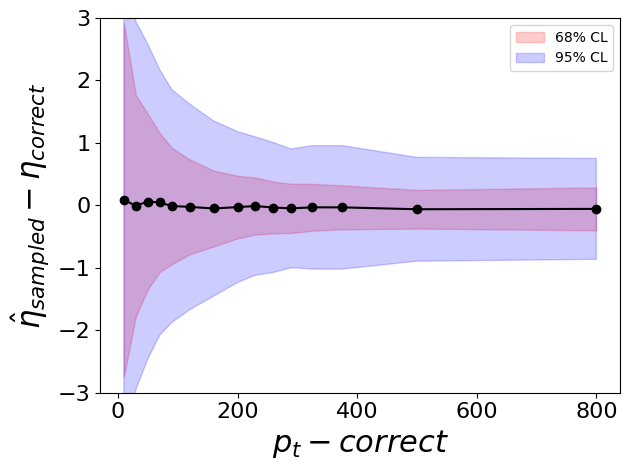

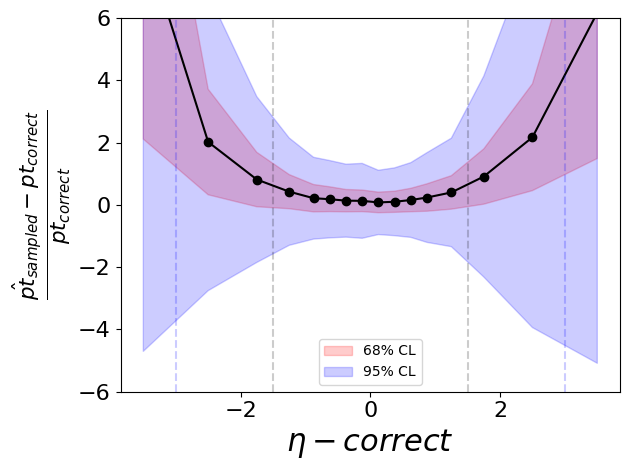

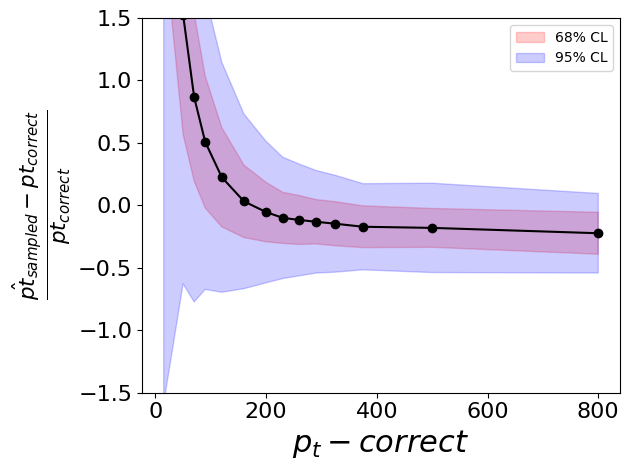

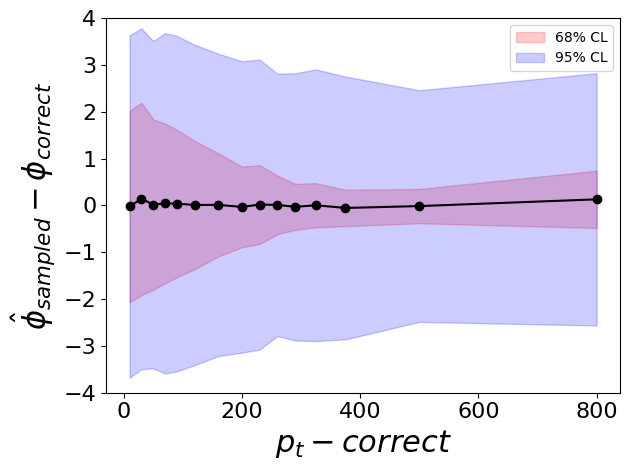

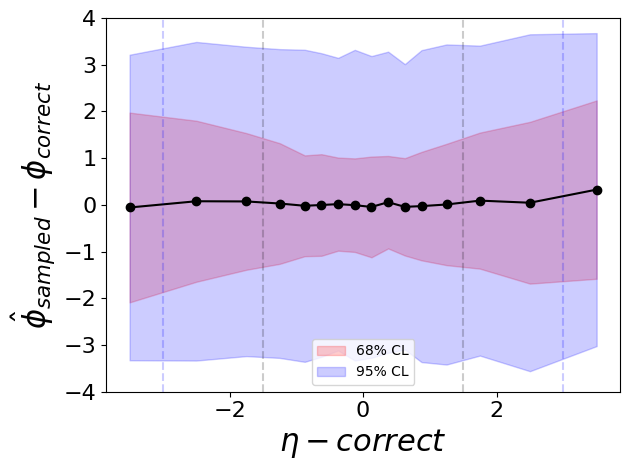

In [38]:
plot_regressionFactor(df.t1_eta + df.delta_t1_eta, df.t1_eta, df.t1_eta, matched=df.Njets>2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$\eta$-correct',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$', eta=True, ratio=False)

plot_regressionFactor(df.t1_eta+df.delta_t1_eta, df.t1_eta,  df.t1_pt,  matched=df.Njets>2,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-3,3], xname='$p_t-correct$',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$')

plot_regressionFactor(df.t1_pt+df.delta_t1_pt, df.t1_pt, df.t1_eta, matched=df.Njets >2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-5, 5), bins=8, ylim=[-6,6], xname='$\eta-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True)

plot_regressionFactor(df.t1_pt+df.delta_t1_pt, df.t1_pt, df.t1_pt,  matched=df.Njets >2,
                      intervalTargetVar=[10,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-1.5,1.5], xname='$p_t-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', ratio=True)

plot_regressionFactor(df.t1_phi+df.delta_t1_phi, df.t1_phi, df.t1_pt, matched=df.Njets>2,
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$')


plot_regressionFactor(df.t1_phi+df.delta_t1_phi, df.t1_phi, df.t1_eta, matched=df.Njets>2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-4,4], xname='$\eta-correct$',
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$', eta=True)

### T leptonic sampling performance

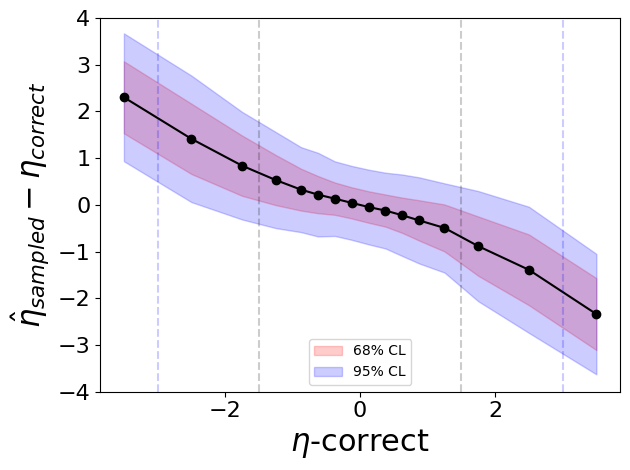

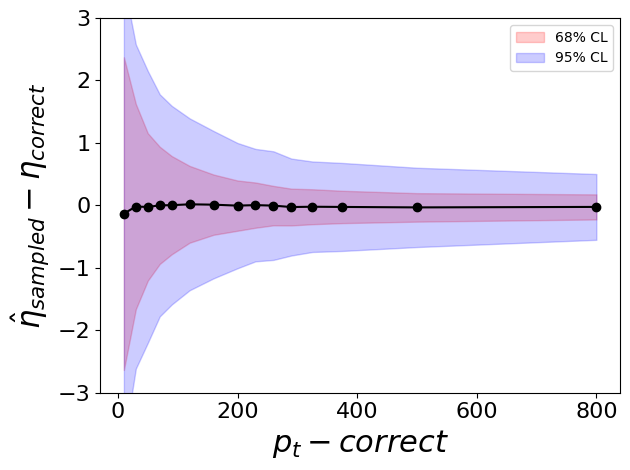

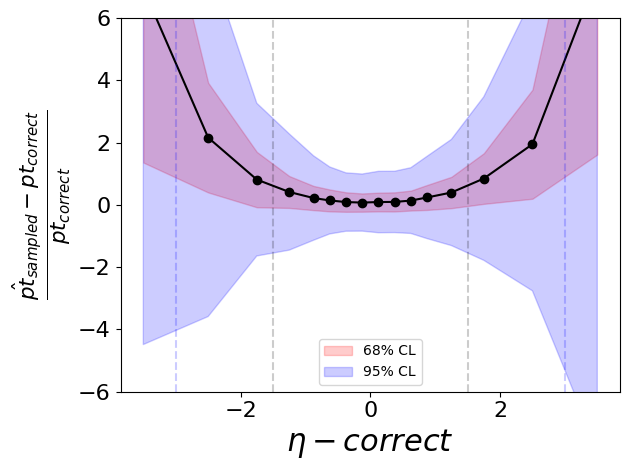

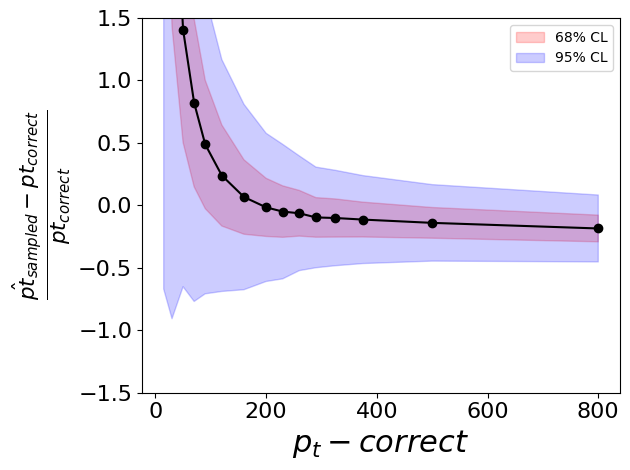

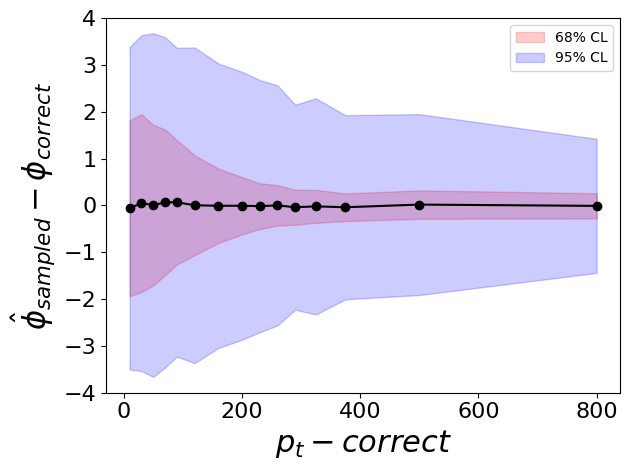

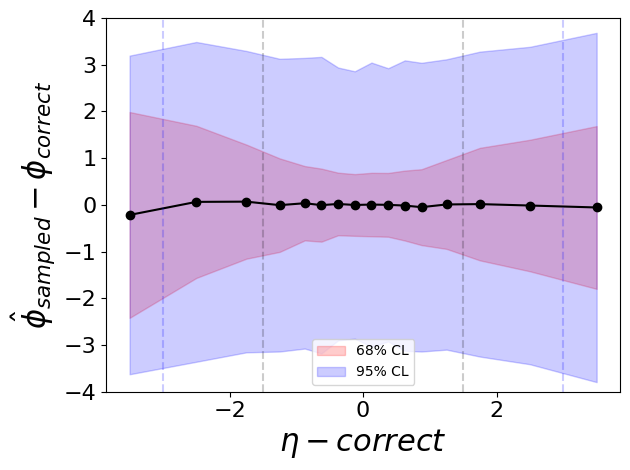

In [39]:
plot_regressionFactor(df.t2_eta + df.delta_t2_eta, df.t2_eta, df.t2_eta, matched=df.Njets>2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$\eta$-correct',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$', eta=True, ratio=False)

plot_regressionFactor(df.t2_eta+df.delta_t2_eta, df.t2_eta,  df.t2_pt,  matched=df.Njets>2,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-3,3], xname='$p_t-correct$',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$')

plot_regressionFactor(df.t2_pt+df.delta_t2_pt, df.t2_pt, df.t2_eta, matched=df.Njets >2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-5, 5), bins=8, ylim=[-6,6], xname='$\eta-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True)

plot_regressionFactor(df.t2_pt+df.delta_t2_pt, df.t2_pt, df.t2_pt,  matched=df.Njets >2,
                      intervalTargetVar=[10,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-1.5,1.5], xname='$p_t-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', ratio=True)

plot_regressionFactor(df.t2_phi+df.delta_t2_phi, df.t2_phi, df.t2_pt, matched=df.Njets>2,
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$')


plot_regressionFactor(df.t2_phi+df.delta_t2_phi, df.t2_phi, df.t2_eta, matched=df.Njets>2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-4,4], xname='$\eta-correct$',
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$', eta=True)

### ISR sampling performance

/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, k

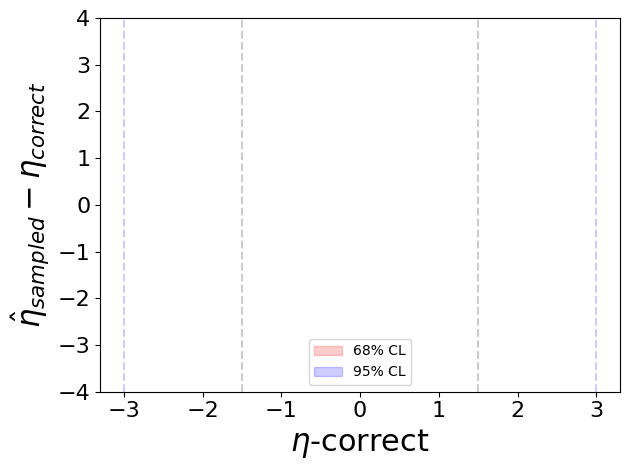

/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/work/dvalsecc/MEM/MEMFlow/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, k

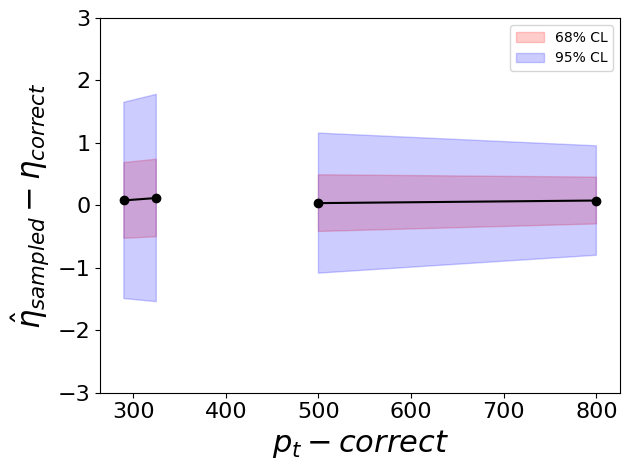

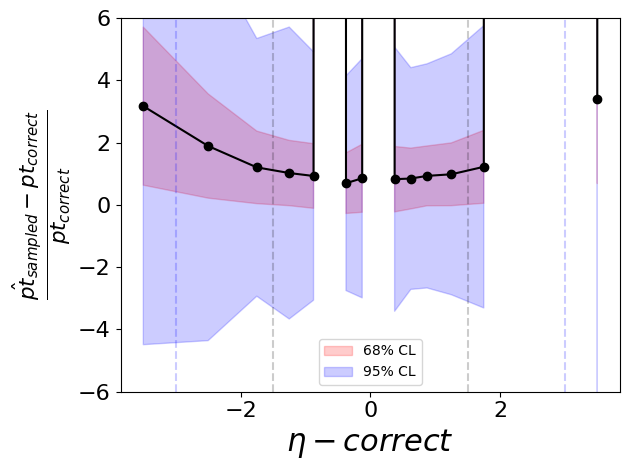

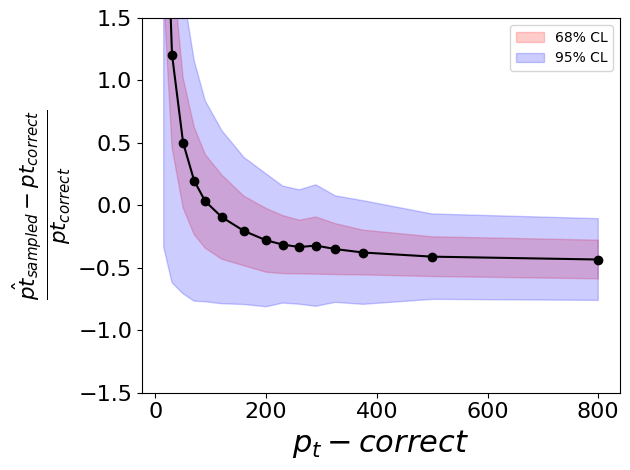

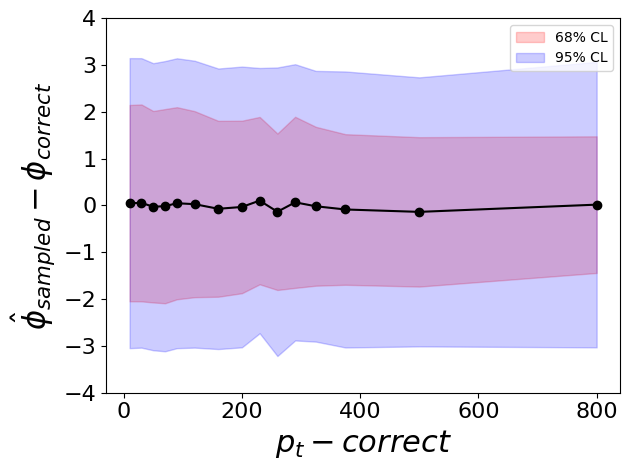

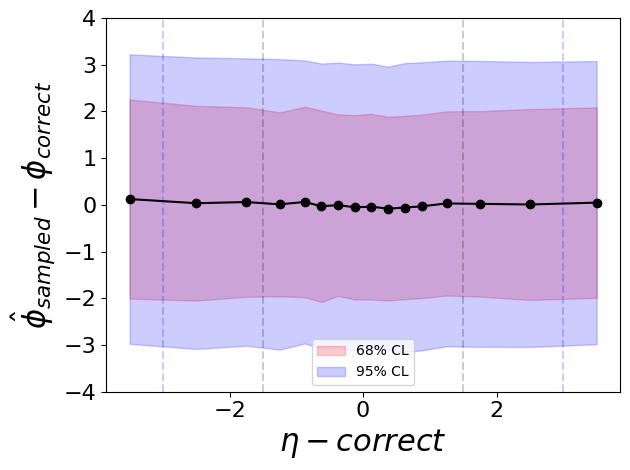

In [41]:
plot_regressionFactor(df.isr_eta + df.delta_isr_eta, df.isr_eta, df.isr_eta, matched=~df.delta_isr_pt.isnull(),
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$\eta$-correct',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$', eta=True, ratio=False)

plot_regressionFactor(df.isr_eta+df.delta_isr_eta, df.isr_eta,  df.isr_pt,  matched=df.Njets>2,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-3,3], xname='$p_t-correct$',
                      yname=r'$\hat{\eta}_{sampled} - \eta_{correct}$')

plot_regressionFactor(df.isr_pt+df.delta_isr_pt, df.isr_pt, df.isr_eta, matched=df.Njets >2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-5, 5), bins=8, ylim=[-6,6], xname='$\eta-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True)

plot_regressionFactor(df.isr_pt+df.delta_isr_pt, df.isr_pt, df.isr_pt,  matched=df.Njets >2,
                      intervalTargetVar=[10,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-1.5,1.5], xname='$p_t-correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', ratio=True)

plot_regressionFactor(df.isr_phi+df.delta_isr_phi, df.isr_phi, df.isr_pt, matched=df.Njets>2,
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$')


plot_regressionFactor(df.isr_phi+df.delta_isr_phi, df.isr_phi, df.isr_eta, matched=df.Njets>2,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-4,4], xname='$\eta-correct$',
                      yname=r'$\hat{\phi}_{sampled} - \phi_{correct}$', eta=True)

(array([2.840e+02, 8.190e+02, 1.281e+03, 1.613e+03, 1.828e+03, 2.044e+03,
        2.076e+03, 2.081e+03, 1.950e+03, 1.876e+03, 1.739e+03, 1.571e+03,
        1.412e+03, 1.331e+03, 1.120e+03, 1.006e+03, 8.540e+02, 7.540e+02,
        7.010e+02, 6.210e+02, 5.220e+02, 4.720e+02, 4.060e+02, 3.730e+02,
        3.150e+02, 2.860e+02, 2.670e+02, 1.940e+02, 1.810e+02, 1.610e+02,
        1.500e+02, 1.320e+02, 1.270e+02, 1.160e+02, 8.800e+01, 7.900e+01,
        8.700e+01, 5.200e+01, 4.500e+01, 4.900e+01, 4.400e+01, 3.600e+01,
        3.800e+01, 2.800e+01, 3.300e+01, 3.300e+01, 2.200e+01, 1.300e+01,
        2.200e+01, 1.700e+01, 1.000e+01, 1.000e+01, 1.600e+01, 1.100e+01,
        1.000e+01, 7.000e+00, 8.000e+00, 7.000e+00, 3.000e+00, 6.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 0.000e+0

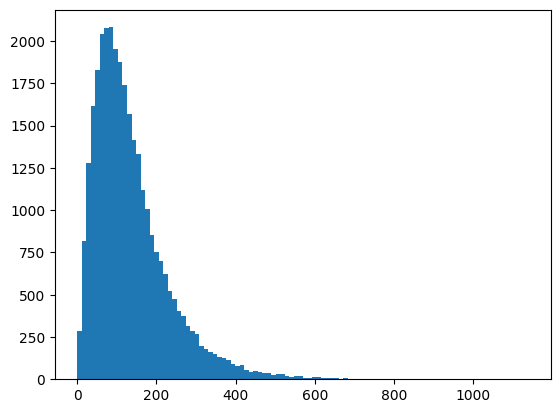

In [45]:
plt.hist(df.H_pt, bins=100)

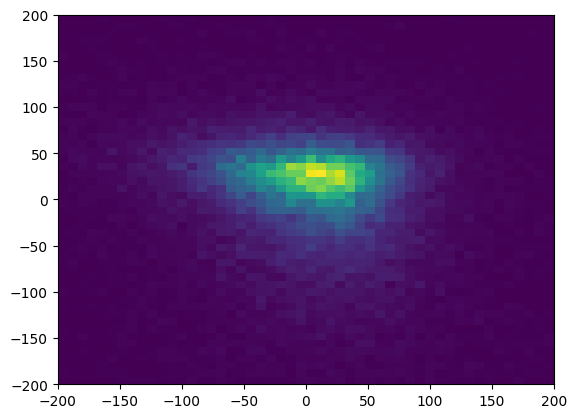

In [42]:
plt.hist2d(
    df.delta_H_pt, 
    df.delta_isr_pt, 
    bins=50, 
    range=((-200,200), (-200,200)), 
    );

In [43]:
plot_regressionFactor(df.H_pt+df.delta_H_pt, df.H_pt, (df.x1+df.x2).cpu().numpy(), matched=df.Njets >2,
                      intervalTargetVar=[0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,1.2],
                      limTarget=(-4, 4), bins=8, ylim=[-2,2], xname='$x1+x2 correct$',
                      yname=r'$\frac{\hat{pt}_{sampled} - pt_{correct}}{pt_{correct}}$', eta=False, ratio=True)


AttributeError: 'Series' object has no attribute 'cpu'

In [44]:
plt.hist((df.x1+df.x2).cpu().numpy(), bins=100)

AttributeError: 'Series' object has no attribute 'cpu'

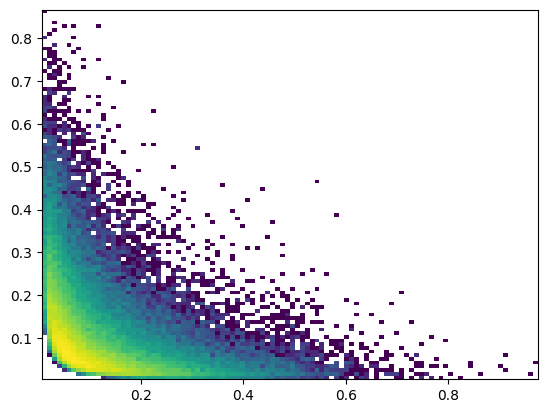

In [117]:
plt.hist2d(df.x1.cpu().numpy(), 
           df.x2.cpu().numpy(),
           bins=(100), norm=LogNorm());

In [ ]:
plt.hist(

In [103]:
boost_parton = data.parton_data.data_boost

In [115]:
x1 = (boost_parton[:,0,0]+boost_parton[:,0,3])/E_CM
x2 = (boost_parton[:,0,0]-boost_parton[:,0,3])/E_CM

df["x1"] = x1[:76800].cpu().numpy()
df["x2"] = x2[:76800].cpu().numpy()

In [116]:
df.x1

tensor([0.1389, 0.3194, 0.0215,  ..., 0.3626, 0.2612, 0.1042], device='cuda:0')